# Evolutionary Multi-Objective Reinforcement Learning for Texas Holdem

In this notebook, I will:

- Define an environment to represent the game of fixed-limit Texas Holdem
- Create six agents:
  - Four to represent the well-known poker player archetypes: 
    - Tight-aggressive (TAG) - A normally tight player who gets aggressive with quality hands.
    - Loose-aggressive (LAG) - A player who aggressively plays lots of hands regardless of quality.
    - Loose-passive (calling station) - A player who plays lots of pots but doesn't aggressively raise quality hands.
    - Tight-passive (nit or rock) - A player who plays few hands and only commits chips with quality hands.
  - And two to represent our RL trained agents.

The RL trained agents will use an evolutionary (genetic) algorithm and evolutionary reinforcement learning techniques. One will be single objective (single policy to maximize winnings) and the other will be multi-objective (a different policy for each of the playing styles noted above).

I will then compare the performance of the single-objective agent to the multi-objective agent.

In [1]:
import copy
import random
from abc import ABC, abstractmethod
from collections.abc import Iterable
from concurrent.futures import ProcessPoolExecutor
from enum import Enum
from multiprocessing import Pool

import matplotlib.pyplot as plt
import numpy as np
from deap import algorithms, base, creator, tools
from pokerkit import (Automation, Card, Deck, FixedLimitTexasHoldem, Rank,
                      StandardHighHand, Suit, calculate_hand_strength,
                      parse_range)
from tqdm import tqdm

In [2]:
# These are the available actions that a player can take
# when it is their turn to act.
class ActionType(Enum):
    FOLD = 0
    CHECK_OR_CALL = 1
    BET_OR_RAISE = 2

# The different streets in Texas Hold'em
class StreetType(Enum):
    PRE_FLOP = 0
    FLOP = 1
    TURN = 2
    RIVER = 3

In [3]:
class PokerEquityCalculator:
    """
    Utility class to calculate the strength of a given hand
    on a given board using Monte Carlo simulations.
    """

    def __init__(self) -> None:
        self._executor = ProcessPoolExecutor()
        self._hand_strength_cache = {}

    def calculate_strength(
        self,
        hand: str,
        board: Iterable[Card],
        players_left_in_hand: int = 5,
        sample_count: int = 250,
    ) -> float:
        cache_key = (hand, tuple(board), players_left_in_hand, sample_count)
        if cache_key in self._hand_strength_cache:
            return self._hand_strength_cache[cache_key]
        strength = calculate_hand_strength(
            player_count=players_left_in_hand,
            hole_range=parse_range(hand),
            board_cards=board,
            hole_dealing_count=2,
            board_dealing_count=5,
            deck=Deck.STANDARD,
            hand_types=(StandardHighHand,),
            sample_count=sample_count,
            executor=self._executor,
        )
        self._hand_strength_cache[cache_key] = strength
        return strength

    def __del__(self) -> None:
        if self._executor:
            self._executor.shutdown(wait=True)
            self._executor = None

In [4]:
class ObservableState:
    """Represents the observable state for a player making game-time decisions."""

    def __init__(
        self,
        hand: Iterable[Iterable[Card]],  # The player's hole cards
        board: Iterable[Card],  # Any cards on the board
        can_fold: bool,  # If the player can fold
        can_check_or_call: bool,  # If the player can check or call
        can_complete_bet_or_raise_to: bool,  # If the player can bet or raise
        players_left_in_hand: int,  # Number of players left in the hand
        hand_strength: float,  # The strength of the player's hand based on who's left and the board
        pot_size: int,  # Current size of the pot
        checking_or_calling_amount: int,  # Amount needed to check or call
        min_completion_betting_or_raising_to_amount: int,  # Minimum amount to bet or raise to
        street: StreetType,  # The current street in the hand
        next_to_act: int,  # The index of the next player to act
        tag_present: bool,  # If a tight-aggressive player is still in the hand
        lag_present: bool,  # If a loose-aggressive player is still in the hand
        tp_present: bool,  # If a tight-passive player is still in the hand
        lp_present: bool,  # If a loose-passive player is still in the hand
    ) -> None:
        self.hand: Iterable[Iterable[Card]] = hand
        self.board: Iterable[Card] = board
        self.can_fold: bool = can_fold
        self.can_check_or_call: bool = can_check_or_call
        self.can_complete_bet_or_raise_to: bool = can_complete_bet_or_raise_to
        self.players_left_in_hand: int = players_left_in_hand
        self.hand_strength: float = hand_strength
        self.pot_size: int = pot_size
        self.checking_or_calling_amount: int = checking_or_calling_amount
        self.min_completion_betting_or_raising_to_amount: int = (
            min_completion_betting_or_raising_to_amount
        )
        self.street: StreetType = street
        self.next_to_act: int = next_to_act

        # calculate pot odds
        self.pot_odds_check_or_call = (
            checking_or_calling_amount / (pot_size + checking_or_calling_amount)
            if can_check_or_call
            else 1.0
        )

        self.pot_odds_bet_or_raise = (
            min_completion_betting_or_raising_to_amount
            / (pot_size + min_completion_betting_or_raising_to_amount)
            if can_complete_bet_or_raise_to
            else 1.0
        )

        self.tag_present = tag_present
        self.lag_present = lag_present
        self.tp_present = tp_present
        self.lp_present = lp_present

In [5]:
class PokerAgent(ABC):
    """A abstract player class. It's policy will be defined per-implementation."""

    @abstractmethod
    def π(self, observation: ObservableState) -> ActionType:
        pass

    def _compute_action(
        self,
        observation: ObservableState,
        strength_to_bet_or_raise_pre_flop: float,
        strength_to_check_or_call_pre_flop: float,
        strength_over_pot_odds_to_bet_or_raise_post_flop: float,
        strength_over_pot_odds_to_check_or_call_post_flop: float,
    ) -> ActionType:
        hand_strength = observation.hand_strength
        pot_odds_check_or_call = observation.pot_odds_check_or_call
        pot_odds_bet_or_raise = observation.pot_odds_bet_or_raise

        if observation.street == StreetType.PRE_FLOP:
            if (
                hand_strength > strength_to_bet_or_raise_pre_flop
                and observation.can_complete_bet_or_raise_to
            ):
                return ActionType.BET_OR_RAISE
            elif (
                hand_strength > strength_to_check_or_call_pre_flop
                or observation.checking_or_calling_amount == 0
                and observation.can_check_or_call
            ):
                return ActionType.CHECK_OR_CALL
            else:
                return ActionType.FOLD
        else:
            if (
                hand_strength - pot_odds_bet_or_raise
                > strength_over_pot_odds_to_bet_or_raise_post_flop
                and observation.can_complete_bet_or_raise_to
            ):
                return ActionType.BET_OR_RAISE
            elif (
                hand_strength - pot_odds_check_or_call
                > strength_over_pot_odds_to_check_or_call_post_flop
                or observation.checking_or_calling_amount == 0
                and observation.can_check_or_call
            ):
                return ActionType.CHECK_OR_CALL
            else:
                return ActionType.FOLD

## PokerPlayer and Agent Implementations

In [6]:
class PokerPlayer:
    """The information needed to represent a player in the poker environment."""

    def __init__(
        self, poker_agent: PokerAgent, player_index: int, stack: int = 100000
    ) -> None:
        """
        Initializes a PokerPlayer.
        Args:
            poker_agent (PokerAgent): The agent controlling this player's decisions/policy.
            player_index (int): The index of the player at the table. Needed for button rotation.
            stack (int): The player's starting stack size.
        """
        self.poker_agent = poker_agent
        self.player_index = player_index
        self.stack = stack

In [7]:
class AgentRandom(PokerAgent):
    """A poker agent that takes random actions from the available action space."""

    def π(self, observation: ObservableState, **kwargs) -> ActionType:
        available_actions = []
        if observation.can_fold:
            available_actions.append(ActionType.FOLD)
        if observation.can_check_or_call:
            available_actions.append(ActionType.CHECK_OR_CALL)
        if observation.can_complete_bet_or_raise_to:
            available_actions.append(ActionType.BET_OR_RAISE)
        return np.random.choice(available_actions)


class AgentTightAggressive(PokerAgent):
    """
    A poker agent that plays a tight-aggressive style. A TAG.
    Requires quality hands to raise. Plays fewer pots.
    """

    def π(self, observation: ObservableState, **kwargs) -> ActionType:
        return self._compute_action(
            observation,
            strength_to_bet_or_raise_pre_flop=0.6,
            strength_to_check_or_call_pre_flop=0.4,
            strength_over_pot_odds_to_bet_or_raise_post_flop=0.1,
            strength_over_pot_odds_to_check_or_call_post_flop=0.0,
        )

class AgentLooseAggressive(PokerAgent):
    """
    A poker agent that plays a loose-aggressive style. A LAG.
    Doesn't need much to raise. Plays lots of pots.
    """

    def π(self, observation: ObservableState, **kwargs) -> ActionType:
        return self._compute_action(
            observation,
            strength_to_bet_or_raise_pre_flop=0.35,
            strength_to_check_or_call_pre_flop=0.25,
            strength_over_pot_odds_to_bet_or_raise_post_flop=-0.05,
            strength_over_pot_odds_to_check_or_call_post_flop=0.05,
        )
    

class AgentTightPassive(PokerAgent):
    """
    A poker agent that plays a tight-passive style. A rock.
    Requires very strong hands to raise or bet. Plays fewer pots.
    """

    def π(self, observation: ObservableState, **kwargs) -> ActionType:
        return self._compute_action(
            observation,
            strength_to_bet_or_raise_pre_flop=0.75,
            strength_to_check_or_call_pre_flop=0.55,
            strength_over_pot_odds_to_bet_or_raise_post_flop=0.25,
            strength_over_pot_odds_to_check_or_call_post_flop=0.15,
        )
    
class AgentLoosePassive(PokerAgent):
    """
    A poker agent that plays a loose-passive style. A calling station.
    Prefers calling to raising. Plays lots of pots.
    """

    def π(self, observation: ObservableState, **kwargs) -> ActionType:
        return self._compute_action(
            observation,
            strength_to_bet_or_raise_pre_flop=0.75,
            strength_to_check_or_call_pre_flop=0.25,
            strength_over_pot_odds_to_bet_or_raise_post_flop=0.50,
            strength_over_pot_odds_to_check_or_call_post_flop=0.25,
        )


In [8]:
class FixedLimitTexasHoldemEnvironment:
    """An environment for Fixed Limit Texas Hold'em Poker"""

    def __init__(self, players: list[PokerPlayer]) -> None:
        self._pokers_equity_calculator = PokerEquityCalculator()
        self._players = players
        starting_stacks = [player.stack for player in self._players]

        self._game = FixedLimitTexasHoldem(
            # We're running a simulation here so no need for people to actually
            # take these actions. These are automated by the engine.
            automations=(
                Automation.ANTE_POSTING,
                Automation.BET_COLLECTION,
                Automation.BLIND_OR_STRADDLE_POSTING,
                Automation.CARD_BURNING,
                Automation.HOLE_DEALING,
                Automation.BOARD_DEALING,
                Automation.HOLE_CARDS_SHOWING_OR_MUCKING,
                Automation.HAND_KILLING,
                Automation.CHIPS_PUSHING,
                Automation.CHIPS_PULLING,
            ),
            ante_trimming_status=True,  # use blinds
            raw_antes=0,
            raw_blinds_or_straddles=(2, 4),
            small_bet=4,
            big_bet=8,
            starting_board_count=1,
        )

        self._state = self._game(
            raw_starting_stacks=starting_stacks,
            player_count=len(self._players),
        )

        self._hand_strength_cache = {}

    def get_next_to_act_player_index(self) -> int:
        next_to_act = self._state.actor_indices[0]
        return self._players[next_to_act].player_index

    def _calculate_hand_strength(self) -> float:
        next_to_act = (
            self._state.actor_indices[0] if len(self._state.actor_indices) > 0 else None
        )
        hole_cards = (
            self._state.hole_cards[next_to_act] if next_to_act is not None else []
        )
        hand = "".join([f"{str(card.rank)}{str(card.suit)}" for card in hole_cards])
        board_cards_flat = (
            [card[0] for card in self._state.board_cards]
            if self._state.board_cards
            else []
        )
        players_left_in_hand = sum(1 for status in self._state.statuses if status)
        return self._pokers_equity_calculator.calculate_strength(
            hand=hand,
            board=board_cards_flat,
            players_left_in_hand=players_left_in_hand,
        )

    def _agent_still_in_hand(self, agent_type: type) -> bool:
        return any(
            isinstance(player.poker_agent, agent_type) and self._state.statuses[i]
            for i, player in enumerate(self._players)
        )

    def reset(self) -> ObservableState:
        """
        Resets the environment to start a new hand with the same players
        Returns the initial observable state.
        """
        # Save the old state. Unsure yet if I will use this.
        self._old_state = copy.deepcopy(self._state)

        # Rotate players for the next hand to reflect the dealer button moving
        # around the table.
        self._players = list(self._players[1:]) + [self._players[0]]

        # Remove any bankrupt players though I will probably
        # make the initial stacks very high to avoid this complication.
        for i, player in enumerate(self._players):
            if player.stack == 0:
                del self._players[i]

        current_stacks = [player.stack for player in self._players]

        # Reset the game state for a new hand
        self._state = self._game(
            raw_starting_stacks=current_stacks,
            player_count=len(self._players),
        )

        next_to_act = self._state.actor_indices[0]
        hand_strength = self._calculate_hand_strength()
        players_left_in_hand = sum(1 for status in self._state.statuses if status)
        return ObservableState(
            hand=self._state.hole_cards[next_to_act],
            board=self._state.board_cards,
            can_fold=self._state.can_fold(),
            can_check_or_call=self._state.can_check_or_call(),
            can_complete_bet_or_raise_to=self._state.can_complete_bet_or_raise_to(),
            players_left_in_hand=players_left_in_hand,
            hand_strength=hand_strength,
            pot_size=self._state.total_pot_amount,
            checking_or_calling_amount=self._state.checking_or_calling_amount,
            min_completion_betting_or_raising_to_amount=self._state.min_completion_betting_or_raising_to_amount,
            street=StreetType.PRE_FLOP,
            next_to_act=self.get_next_to_act_player_index(),
            tag_present=self._agent_still_in_hand(AgentTightAggressive),
            lag_present=self._agent_still_in_hand(AgentLooseAggressive),
            tp_present=self._agent_still_in_hand(AgentTightPassive),
            lp_present=self._agent_still_in_hand(AgentLoosePassive),
        )

    def action_space(self) -> list[ActionType]:
        """Returns the action space (what the player can do right now) for the environment."""
        available_actions = []
        if self._state.can_fold():
            available_actions.append(ActionType.FOLD)
        if self._state.can_check_or_call():
            available_actions.append(ActionType.CHECK_OR_CALL)
        if self._state.can_bet_or_raise():
            available_actions.append(ActionType.BET_OR_RAISE)
        return available_actions

    def step(self, action: ActionType) -> dict:
        """
        Takes a step in the environment based on the action and returns:
            - state: the new state of the environment
            - reward: the reward obtained from taking the action
            - done: whether the hand is over
        """
        board_len = len(self._state.board_cards)
        street = StreetType.PRE_FLOP
        if board_len == 3:
            street = StreetType.FLOP
        elif board_len == 4:
            street = StreetType.TURN
        elif board_len == 5:
            street = StreetType.RIVER

        # Take the action
        if action == ActionType.FOLD:
            self._state.fold()
        elif action == ActionType.CHECK_OR_CALL:
            self._state.check_or_call()
        elif action == ActionType.BET_OR_RAISE:
            self._state.complete_bet_or_raise_to()

        done = not self._state.status
        rewards = None
        if done:
            # update player stacks
            for i, player in enumerate(self._players):
                player.stack = self._state.stacks[i]
            # gather rewards
            payoffs = self._state.payoffs
            rewards = [0] * len(self._players)
            # Unwind the shifting of the players to account
            # for the dealer button moving.
            for i, player in enumerate(self._players):
                rewards[player.player_index] = payoffs[i]

            # Add a small penalty for folding early
            for i, reward in enumerate(rewards):
                rewards[i] = -2 if reward == 0 else reward

        self._old_state = copy.deepcopy(self._state)

        next_to_act = (
            self._state.actor_indices[0] if self._state.actor_indices else None
        )
        hand_strength = self._calculate_hand_strength() if not done else 0.0
        players_left_in_hand = sum(1 for status in self._state.statuses if status)
        observation = ObservableState(
            hand=self._state.hole_cards[next_to_act] if not done else [],
            board=self._state.board_cards if not done else [],
            can_fold=self._state.can_fold(),
            can_check_or_call=self._state.can_check_or_call(),
            can_complete_bet_or_raise_to=self._state.can_complete_bet_or_raise_to(),
            players_left_in_hand=players_left_in_hand,
            hand_strength=hand_strength,
            pot_size=self._state.total_pot_amount,
            checking_or_calling_amount=self._state.checking_or_calling_amount,
            min_completion_betting_or_raising_to_amount=self._state.min_completion_betting_or_raising_to_amount,
            street=street,
            next_to_act=(
                self.get_next_to_act_player_index()
                if self._state.actor_indices
                else None
            ),
            tag_present=self._agent_still_in_hand(AgentTightAggressive),
            lag_present=self._agent_still_in_hand(AgentLooseAggressive),
            tp_present=self._agent_still_in_hand(AgentTightPassive),
            lp_present=self._agent_still_in_hand(AgentLoosePassive),
        )

        return {
            "observation": observation,
            "done": done,
            "rewards": rewards,
        }

In [9]:
# Sanity check of the coded agents rules
observation = ObservableState(
    hand=[[Card(Rank.ACE, Suit.SPADE), Card(Rank.ACE, Suit.HEART)]],
    board=[
        Card(Rank.KING, Suit.DIAMOND),
        Card(Rank.QUEEN, Suit.SPADE),
        Card(Rank.JACK, Suit.CLUB),
    ],
    can_fold=True,
    can_check_or_call=True,
    can_complete_bet_or_raise_to=True,
    players_left_in_hand=4,
    hand_strength=0.3,
    pot_size=12,
    checking_or_calling_amount=4,
    min_completion_betting_or_raising_to_amount=4,
    street=StreetType.FLOP,
    next_to_act=0,
    tag_present=True,
    lag_present=True,
    tp_present=True,
    lp_present=True,
)

print("Sanity check of the agent configurations:")
print("-" * 65)

tag = AgentTightAggressive()
action = tag.π(observation)
print(f"Selected tight aggressive action:\t{action}")

rock = AgentTightPassive()
action = rock.π(observation)
print(f"Selected tight passive action:\t\t{action}")

lag = AgentLooseAggressive()
action = lag.π(observation)
print(f"Selected loose aggressive action:\t{action}")

calling_station = AgentLoosePassive()
action = calling_station.π(observation)
print(f"Selected loose passive action:\t\t{action}")

Sanity check of the agent configurations:
-----------------------------------------------------------------
Selected tight aggressive action:	ActionType.CHECK_OR_CALL
Selected tight passive action:		ActionType.FOLD
Selected loose aggressive action:	ActionType.BET_OR_RAISE
Selected loose passive action:		ActionType.FOLD


## Playing Poker

The following method is used to complete 1 episode (hand of poker).

In [10]:
def play_one_hand_of_poker(
    env: FixedLimitTexasHoldemEnvironment,
    players: list[PokerPlayer],
    actions_taken: list[list[ActionType]],
    θ: np.ndarray = None,
    θs: list[np.ndarray] = None,
) -> list[int]:
    """
    Claude 4.5: I tab completed the docstring.
    Play one hand of poker (episode) in the provided environment.
    Args:
        env (FixedLimitTexasHoldemEnvironment): The poker environment.
        players (list[PokerPlayer]): The players in the environment.
        actions_taken (list[list[ActionType]]): A list to record the actions taken by
            each player for graphing later.
        θ (np.ndarray, optional): Supplied when training/evaluating a single-objective evolutionary agent. Ignored otherwise.
        θs (list[np.ndarray], optional): Supplied when training/evaluating multi-objective evolutionary agents. Ignored otherwise.
    Returns:
        list[int]: The rewards obtained by each player at the end of the hand.
    """
    assert θ is None or θs is None, "Cannot specify both θ and θs."
    observation = env.reset()
    done = False

    while not done:
        next_to_act_index = observation.next_to_act
        next_to_act = players[next_to_act_index]

        # Figure out which θ to use
        theta_to_use = θ

        if θs is not None:
            # Determine how many players are left
            opponent_count = sum(
                [
                    observation.tag_present,
                    observation.lag_present,
                    observation.tp_present,
                    observation.lp_present,
                ]
            )
            
            # Use the specialized policies if there is only one opponent left
            if opponent_count == 1:
                if observation.tag_present:
                    theta_to_use = θs[1]
                elif observation.lag_present:
                    theta_to_use = θs[2]
                elif observation.tp_present:
                    theta_to_use = θs[3]
                elif observation.lp_present:
                    theta_to_use = θs[4]
            else:
                # Multiple opponents are still in the hand, use the general policy
                theta_to_use = θs[0]

        # Get the action from the agent's policy function π
        action = next_to_act.poker_agent.π(observation, θ=theta_to_use)

        # Save the actions taken for graphing later
        actions_taken[next_to_act_index].append(action)

        # Take a step
        step_result = env.step(action)

        observation = step_result["observation"]
        done = step_result["done"]
        if done:
            # We only have rewards at the end of the hand
            rewards = step_result["rewards"]

    return rewards

## Random Agent Baseline

In the following section, I will let the random agent compete against the coded agents to establish a baseline.

In [11]:
starting_stack = int(1e12)  # Start high to avoid going bankrupt
player_0 = PokerPlayer(poker_agent=AgentRandom(), player_index=0, stack=starting_stack)
player_1 = PokerPlayer(
    poker_agent=AgentTightAggressive(), player_index=1, stack=starting_stack
)
player_2 = PokerPlayer(
    poker_agent=AgentLooseAggressive(), player_index=2, stack=starting_stack
)
player_3 = PokerPlayer(
    poker_agent=AgentTightPassive(), player_index=3, stack=starting_stack
)
player_4 = PokerPlayer(
    poker_agent=AgentLoosePassive(), player_index=4, stack=starting_stack
)
players = [player_0, player_1, player_2, player_3, player_4]
actions_taken = [[] for _ in players]
rewards_over_time = [[] for _ in players]

env = FixedLimitTexasHoldemEnvironment(players=players)
num_hands = 100

for hand in tqdm(
    range(num_hands), desc="Playing hands with random agent vs. coded agents."
):
    rewards = play_one_hand_of_poker(
        env=env,
        players=players,
        actions_taken=actions_taken,
    )

    # Save the rewards for graphing later
    for i, reward in enumerate(rewards):
        rewards_over_time[i].append(reward)

    print(f"Completed hand {hand}.")
    print(f"Player stacks: {[player.stack for player in players]}")

Playing hands with random agent vs. coded agents.:   1%|          | 1/100 [00:00<01:12,  1.36it/s]

Completed hand 0.
Player stacks: [1000000000000, 1000000000100, 999999999900, 1000000000000, 1000000000000]


Playing hands with random agent vs. coded agents.:   2%|▏         | 2/100 [00:01<00:52,  1.87it/s]

Completed hand 1.
Player stacks: [999999999976, 1000000000100, 999999999928, 999999999996, 1000000000000]


Playing hands with random agent vs. coded agents.:   3%|▎         | 3/100 [00:01<00:48,  1.99it/s]

Completed hand 2.
Player stacks: [999999999968, 1000000000100, 999999999962, 999999999994, 999999999976]


Playing hands with random agent vs. coded agents.:   4%|▍         | 4/100 [00:02<00:51,  1.85it/s]

Completed hand 3.
Player stacks: [999999999940, 1000000000100, 999999999994, 999999999994, 999999999972]


Playing hands with random agent vs. coded agents.:   5%|▌         | 5/100 [00:02<00:56,  1.67it/s]

Completed hand 4.
Player stacks: [999999999912, 1000000000096, 999999999994, 999999999994, 1000000000004]


Playing hands with random agent vs. coded agents.:   6%|▌         | 6/100 [00:03<00:55,  1.69it/s]

Completed hand 5.
Player stacks: [999999999900, 1000000000094, 1000000000020, 999999999994, 999999999992]


Playing hands with random agent vs. coded agents.:   7%|▋         | 7/100 [00:03<00:45,  2.06it/s]

Completed hand 6.
Player stacks: [999999999884, 1000000000094, 1000000000018, 1000000000012, 999999999992]


Playing hands with random agent vs. coded agents.:   8%|▊         | 8/100 [00:04<00:43,  2.10it/s]

Completed hand 7.
Player stacks: [999999999884, 1000000000094, 1000000000014, 1000000000010, 999999999998]


Playing hands with random agent vs. coded agents.:   9%|▉         | 9/100 [00:04<00:46,  1.95it/s]

Completed hand 8.
Player stacks: [999999999864, 1000000000094, 1000000000046, 1000000000010, 999999999986]


Playing hands with random agent vs. coded agents.:  10%|█         | 10/100 [00:05<00:42,  2.11it/s]

Completed hand 9.
Player stacks: [999999999872, 1000000000090, 1000000000046, 1000000000010, 999999999982]


Playing hands with random agent vs. coded agents.:  11%|█         | 11/100 [00:06<00:57,  1.56it/s]

Completed hand 10.
Player stacks: [999999999848, 1000000000088, 999999999958, 1000000000010, 1000000000096]


Playing hands with random agent vs. coded agents.:  12%|█▏        | 12/100 [00:06<00:52,  1.68it/s]

Completed hand 11.
Player stacks: [999999999836, 1000000000088, 999999999956, 1000000000024, 1000000000096]


Playing hands with random agent vs. coded agents.:  13%|█▎        | 13/100 [00:07<00:46,  1.86it/s]

Completed hand 12.
Player stacks: [999999999828, 1000000000088, 999999999956, 1000000000022, 1000000000106]


Playing hands with random agent vs. coded agents.:  14%|█▍        | 14/100 [00:07<00:44,  1.94it/s]

Completed hand 13.
Player stacks: [999999999820, 1000000000088, 999999999924, 1000000000022, 1000000000146]


Playing hands with random agent vs. coded agents.:  15%|█▌        | 15/100 [00:08<00:46,  1.83it/s]

Completed hand 14.
Player stacks: [999999999818, 1000000000091, 999999999927, 1000000000022, 1000000000142]


Playing hands with random agent vs. coded agents.:  17%|█▋        | 17/100 [00:08<00:35,  2.36it/s]

Completed hand 15.
Player stacks: [999999999818, 1000000000089, 999999999957, 1000000000022, 1000000000114]
Completed hand 16.
Player stacks: [999999999818, 1000000000089, 999999999961, 1000000000018, 1000000000114]


Playing hands with random agent vs. coded agents.:  18%|█▊        | 18/100 [00:09<00:36,  2.23it/s]

Completed hand 17.
Player stacks: [999999999810, 1000000000089, 999999999901, 1000000000016, 1000000000184]


Playing hands with random agent vs. coded agents.:  19%|█▉        | 19/100 [00:09<00:38,  2.11it/s]

Completed hand 18.
Player stacks: [999999999802, 1000000000089, 999999999901, 1000000000016, 1000000000192]


Playing hands with random agent vs. coded agents.:  20%|██        | 20/100 [00:10<00:41,  1.92it/s]

Completed hand 19.
Player stacks: [999999999762, 1000000000169, 999999999901, 1000000000016, 1000000000152]


Playing hands with random agent vs. coded agents.:  21%|██        | 21/100 [00:11<00:41,  1.89it/s]

Completed hand 20.
Player stacks: [999999999742, 1000000000167, 999999999813, 1000000000016, 1000000000262]


Playing hands with random agent vs. coded agents.:  22%|██▏       | 22/100 [00:11<00:36,  2.13it/s]

Completed hand 21.
Player stacks: [999999999734, 1000000000167, 999999999811, 1000000000026, 1000000000262]


Playing hands with random agent vs. coded agents.:  23%|██▎       | 23/100 [00:11<00:33,  2.32it/s]

Completed hand 22.
Player stacks: [999999999740, 1000000000167, 999999999811, 1000000000024, 1000000000258]


Playing hands with random agent vs. coded agents.:  24%|██▍       | 24/100 [00:12<00:33,  2.25it/s]

Completed hand 23.
Player stacks: [999999999716, 1000000000167, 999999999811, 1000000000056, 1000000000250]


Playing hands with random agent vs. coded agents.:  25%|██▌       | 25/100 [00:12<00:30,  2.46it/s]

Completed hand 24.
Player stacks: [999999999728, 1000000000163, 999999999811, 1000000000056, 1000000000242]


Playing hands with random agent vs. coded agents.:  26%|██▌       | 26/100 [00:12<00:30,  2.43it/s]

Completed hand 25.
Player stacks: [999999999728, 1000000000095, 999999999879, 1000000000056, 1000000000242]


Playing hands with random agent vs. coded agents.:  27%|██▋       | 27/100 [00:13<00:32,  2.22it/s]

Completed hand 26.
Player stacks: [999999999676, 1000000000095, 999999999935, 1000000000052, 1000000000242]


Playing hands with random agent vs. coded agents.:  28%|██▊       | 28/100 [00:13<00:32,  2.19it/s]

Completed hand 27.
Player stacks: [999999999668, 1000000000095, 999999999859, 1000000000050, 1000000000328]


Playing hands with random agent vs. coded agents.:  29%|██▉       | 29/100 [00:14<00:31,  2.23it/s]

Completed hand 28.
Player stacks: [999999999656, 1000000000095, 999999999875, 1000000000050, 1000000000324]


Playing hands with random agent vs. coded agents.:  30%|███       | 30/100 [00:14<00:30,  2.28it/s]

Completed hand 29.
Player stacks: [999999999654, 1000000000181, 999999999791, 1000000000050, 1000000000324]


Playing hands with random agent vs. coded agents.:  31%|███       | 31/100 [00:15<00:28,  2.46it/s]

Completed hand 30.
Player stacks: [999999999626, 1000000000179, 999999999821, 1000000000050, 1000000000324]


Playing hands with random agent vs. coded agents.:  32%|███▏      | 32/100 [00:15<00:27,  2.46it/s]

Completed hand 31.
Player stacks: [999999999618, 1000000000179, 999999999841, 1000000000046, 1000000000316]


Playing hands with random agent vs. coded agents.:  33%|███▎      | 33/100 [00:15<00:24,  2.71it/s]

Completed hand 32.
Player stacks: [999999999610, 1000000000179, 999999999841, 1000000000044, 1000000000326]


Playing hands with random agent vs. coded agents.:  34%|███▍      | 34/100 [00:16<00:22,  2.97it/s]

Completed hand 33.
Player stacks: [999999999614, 1000000000179, 999999999841, 1000000000044, 1000000000322]


Playing hands with random agent vs. coded agents.:  35%|███▌      | 35/100 [00:16<00:28,  2.27it/s]

Completed hand 34.
Player stacks: [999999999598, 1000000000299, 999999999749, 1000000000044, 1000000000310]


Playing hands with random agent vs. coded agents.:  36%|███▌      | 36/100 [00:17<00:29,  2.15it/s]

Completed hand 35.
Player stacks: [999999999598, 1000000000215, 999999999837, 1000000000044, 1000000000306]


Playing hands with random agent vs. coded agents.:  37%|███▋      | 37/100 [00:17<00:28,  2.22it/s]

Completed hand 36.
Player stacks: [999999999546, 1000000000215, 999999999893, 1000000000040, 1000000000306]


Playing hands with random agent vs. coded agents.:  38%|███▊      | 38/100 [00:18<00:27,  2.27it/s]

Completed hand 37.
Player stacks: [999999999534, 1000000000215, 999999999893, 1000000000038, 1000000000320]


Playing hands with random agent vs. coded agents.:  40%|████      | 40/100 [00:18<00:19,  3.01it/s]

Completed hand 38.
Player stacks: [999999999546, 1000000000215, 999999999893, 1000000000038, 1000000000308]
Completed hand 39.
Player stacks: [999999999544, 1000000000217, 999999999893, 1000000000038, 1000000000308]


Playing hands with random agent vs. coded agents.:  41%|████      | 41/100 [00:18<00:17,  3.33it/s]

Completed hand 40.
Player stacks: [999999999540, 1000000000215, 999999999899, 1000000000038, 1000000000308]


Playing hands with random agent vs. coded agents.:  42%|████▏     | 42/100 [00:19<00:19,  3.01it/s]

Completed hand 41.
Player stacks: [999999999540, 1000000000215, 999999999907, 1000000000034, 1000000000304]


Playing hands with random agent vs. coded agents.:  43%|████▎     | 43/100 [00:19<00:23,  2.43it/s]

Completed hand 42.
Player stacks: [999999999610, 1000000000215, 999999999847, 1000000000032, 1000000000296]


Playing hands with random agent vs. coded agents.:  44%|████▍     | 44/100 [00:20<00:21,  2.60it/s]

Completed hand 43.
Player stacks: [999999999578, 1000000000215, 999999999881, 1000000000032, 1000000000294]


Playing hands with random agent vs. coded agents.:  45%|████▌     | 45/100 [00:20<00:20,  2.62it/s]

Completed hand 44.
Player stacks: [999999999562, 1000000000211, 999999999901, 1000000000032, 1000000000294]


Playing hands with random agent vs. coded agents.:  46%|████▌     | 46/100 [00:20<00:22,  2.45it/s]

Completed hand 45.
Player stacks: [999999999546, 1000000000209, 999999999837, 1000000000032, 1000000000376]


Playing hands with random agent vs. coded agents.:  47%|████▋     | 47/100 [00:21<00:25,  2.08it/s]

Completed hand 46.
Player stacks: [999999999614, 1000000000209, 999999999785, 1000000000028, 1000000000364]


Playing hands with random agent vs. coded agents.:  48%|████▊     | 48/100 [00:22<00:24,  2.11it/s]

Completed hand 47.
Player stacks: [999999999566, 1000000000209, 999999999839, 1000000000026, 1000000000360]


Playing hands with random agent vs. coded agents.:  49%|████▉     | 49/100 [00:22<00:20,  2.46it/s]

Completed hand 48.
Player stacks: [999999999546, 1000000000209, 999999999839, 1000000000026, 1000000000380]


Playing hands with random agent vs. coded agents.:  50%|█████     | 50/100 [00:22<00:23,  2.15it/s]

Completed hand 49.
Player stacks: [999999999530, 1000000000205, 999999999899, 1000000000026, 1000000000340]


Playing hands with random agent vs. coded agents.:  51%|█████     | 51/100 [00:23<00:24,  1.99it/s]

Completed hand 50.
Player stacks: [999999999462, 1000000000193, 999999999979, 1000000000026, 1000000000340]


Playing hands with random agent vs. coded agents.:  52%|█████▏    | 52/100 [00:23<00:21,  2.21it/s]

Completed hand 51.
Player stacks: [999999999454, 1000000000193, 999999999991, 1000000000022, 1000000000340]


Playing hands with random agent vs. coded agents.:  53%|█████▎    | 53/100 [00:24<00:20,  2.28it/s]

Completed hand 52.
Player stacks: [999999999454, 1000000000193, 999999999903, 1000000000020, 1000000000430]


Playing hands with random agent vs. coded agents.:  54%|█████▍    | 54/100 [00:24<00:23,  1.98it/s]

Completed hand 53.
Player stacks: [999999999422, 1000000000193, 999999999803, 1000000000154, 1000000000428]


Playing hands with random agent vs. coded agents.:  55%|█████▌    | 55/100 [00:25<00:20,  2.19it/s]

Completed hand 54.
Player stacks: [999999999426, 1000000000189, 999999999803, 1000000000154, 1000000000428]


Playing hands with random agent vs. coded agents.:  56%|█████▌    | 56/100 [00:25<00:18,  2.33it/s]

Completed hand 55.
Player stacks: [999999999444, 1000000000187, 999999999799, 1000000000154, 1000000000416]


Playing hands with random agent vs. coded agents.:  57%|█████▋    | 57/100 [00:26<00:17,  2.44it/s]

Completed hand 56.
Player stacks: [999999999424, 1000000000187, 999999999823, 1000000000150, 1000000000416]


Playing hands with random agent vs. coded agents.:  58%|█████▊    | 58/100 [00:26<00:20,  2.06it/s]

Completed hand 57.
Player stacks: [999999999400, 1000000000187, 999999999823, 1000000000148, 1000000000442]


Playing hands with random agent vs. coded agents.:  59%|█████▉    | 59/100 [00:27<00:21,  1.92it/s]

Completed hand 58.
Player stacks: [999999999380, 1000000000187, 999999999823, 1000000000148, 1000000000462]


Playing hands with random agent vs. coded agents.:  60%|██████    | 60/100 [00:27<00:20,  1.91it/s]

Completed hand 59.
Player stacks: [999999999378, 1000000000193, 999999999823, 1000000000148, 1000000000458]


Playing hands with random agent vs. coded agents.:  61%|██████    | 61/100 [00:28<00:18,  2.07it/s]

Completed hand 60.
Player stacks: [999999999366, 1000000000191, 999999999837, 1000000000148, 1000000000458]


Playing hands with random agent vs. coded agents.:  62%|██████▏   | 62/100 [00:28<00:19,  1.90it/s]

Completed hand 61.
Player stacks: [999999999350, 1000000000191, 999999999835, 1000000000144, 1000000000480]


Playing hands with random agent vs. coded agents.:  63%|██████▎   | 63/100 [00:29<00:17,  2.09it/s]

Completed hand 62.
Player stacks: [999999999360, 1000000000191, 999999999835, 1000000000142, 1000000000472]


Playing hands with random agent vs. coded agents.:  64%|██████▍   | 64/100 [00:29<00:17,  2.03it/s]

Completed hand 63.
Player stacks: [999999999344, 1000000000301, 999999999743, 1000000000142, 1000000000470]


Playing hands with random agent vs. coded agents.:  65%|██████▌   | 65/100 [00:30<00:22,  1.56it/s]

Completed hand 64.
Player stacks: [999999999312, 1000000000297, 999999999679, 1000000000142, 1000000000570]


Playing hands with random agent vs. coded agents.:  66%|██████▌   | 66/100 [00:31<00:22,  1.51it/s]

Completed hand 65.
Player stacks: [999999999272, 1000000000295, 999999999741, 1000000000142, 1000000000550]


Playing hands with random agent vs. coded agents.:  67%|██████▋   | 67/100 [00:31<00:17,  1.90it/s]

Completed hand 66.
Player stacks: [999999999272, 1000000000295, 999999999745, 1000000000138, 1000000000550]


Playing hands with random agent vs. coded agents.:  68%|██████▊   | 68/100 [00:32<00:19,  1.65it/s]

Completed hand 67.
Player stacks: [999999999236, 1000000000295, 999999999859, 1000000000136, 1000000000474]


Playing hands with random agent vs. coded agents.:  69%|██████▉   | 69/100 [00:32<00:17,  1.73it/s]

Completed hand 68.
Player stacks: [999999999244, 1000000000295, 999999999859, 1000000000136, 1000000000466]


Playing hands with random agent vs. coded agents.:  70%|███████   | 70/100 [00:33<00:17,  1.68it/s]

Completed hand 69.
Player stacks: [999999999228, 1000000000315, 999999999859, 1000000000136, 1000000000462]


Playing hands with random agent vs. coded agents.:  71%|███████   | 71/100 [00:34<00:16,  1.76it/s]

Completed hand 70.
Player stacks: [999999999208, 1000000000313, 999999999881, 1000000000136, 1000000000462]


Playing hands with random agent vs. coded agents.:  72%|███████▏  | 72/100 [00:34<00:18,  1.51it/s]

Completed hand 71.
Player stacks: [999999999148, 1000000000379, 999999999879, 1000000000132, 1000000000462]


Playing hands with random agent vs. coded agents.:  73%|███████▎  | 73/100 [00:35<00:17,  1.53it/s]

Completed hand 72.
Player stacks: [999999999148, 1000000000379, 999999999913, 1000000000130, 1000000000430]


Playing hands with random agent vs. coded agents.:  74%|███████▍  | 74/100 [00:36<00:17,  1.50it/s]

Completed hand 73.
Player stacks: [999999999136, 1000000000379, 999999999937, 1000000000130, 1000000000418]


Playing hands with random agent vs. coded agents.:  75%|███████▌  | 75/100 [00:36<00:15,  1.63it/s]

Completed hand 74.
Player stacks: [999999999112, 1000000000403, 999999999937, 1000000000130, 1000000000418]


Playing hands with random agent vs. coded agents.:  76%|███████▌  | 76/100 [00:37<00:15,  1.58it/s]

Completed hand 75.
Player stacks: [999999999112, 1000000000451, 999999999889, 1000000000130, 1000000000418]


Playing hands with random agent vs. coded agents.:  77%|███████▋  | 77/100 [00:37<00:12,  1.83it/s]

Completed hand 76.
Player stacks: [999999999112, 1000000000451, 999999999893, 1000000000126, 1000000000418]


Playing hands with random agent vs. coded agents.:  78%|███████▊  | 78/100 [00:38<00:11,  1.84it/s]

Completed hand 77.
Player stacks: [999999999112, 1000000000451, 999999999923, 1000000000124, 1000000000390]


Playing hands with random agent vs. coded agents.:  79%|███████▉  | 79/100 [00:38<00:10,  1.94it/s]

Completed hand 78.
Player stacks: [999999999100, 1000000000451, 999999999923, 1000000000124, 1000000000402]


Playing hands with random agent vs. coded agents.:  80%|████████  | 80/100 [00:39<00:11,  1.69it/s]

Completed hand 79.
Player stacks: [999999999116, 1000000000447, 999999999923, 1000000000124, 1000000000390]


Playing hands with random agent vs. coded agents.:  81%|████████  | 81/100 [00:40<00:12,  1.52it/s]

Completed hand 80.
Player stacks: [999999999142, 1000000000445, 999999999919, 1000000000124, 1000000000370]


Playing hands with random agent vs. coded agents.:  82%|████████▏ | 82/100 [00:40<00:11,  1.58it/s]

Completed hand 81.
Player stacks: [999999999134, 1000000000445, 999999999931, 1000000000120, 1000000000370]


Playing hands with random agent vs. coded agents.:  83%|████████▎ | 83/100 [00:41<00:10,  1.69it/s]

Completed hand 82.
Player stacks: [999999999140, 1000000000445, 999999999931, 1000000000118, 1000000000366]


Playing hands with random agent vs. coded agents.:  84%|████████▍ | 84/100 [00:41<00:09,  1.73it/s]

Completed hand 83.
Player stacks: [999999999128, 1000000000445, 999999999931, 1000000000118, 1000000000378]


Playing hands with random agent vs. coded agents.:  85%|████████▌ | 85/100 [00:42<00:08,  1.78it/s]

Completed hand 84.
Player stacks: [999999999144, 1000000000441, 999999999931, 1000000000118, 1000000000366]


Playing hands with random agent vs. coded agents.:  86%|████████▌ | 86/100 [00:42<00:06,  2.02it/s]

Completed hand 85.
Player stacks: [999999999150, 1000000000439, 999999999927, 1000000000118, 1000000000366]


Playing hands with random agent vs. coded agents.:  87%|████████▋ | 87/100 [00:43<00:06,  1.98it/s]

Completed hand 86.
Player stacks: [999999999142, 1000000000439, 999999999939, 1000000000114, 1000000000366]


Playing hands with random agent vs. coded agents.:  88%|████████▊ | 88/100 [00:44<00:07,  1.71it/s]

Completed hand 87.
Player stacks: [999999999106, 1000000000439, 999999999939, 1000000000112, 1000000000404]


Playing hands with random agent vs. coded agents.:  89%|████████▉ | 89/100 [00:44<00:06,  1.80it/s]

Completed hand 88.
Player stacks: [999999999102, 1000000000439, 999999999939, 1000000000112, 1000000000408]


Playing hands with random agent vs. coded agents.:  90%|█████████ | 90/100 [00:45<00:05,  1.89it/s]

Completed hand 89.
Player stacks: [999999999078, 1000000000435, 999999999939, 1000000000112, 1000000000436]


Playing hands with random agent vs. coded agents.:  91%|█████████ | 91/100 [00:45<00:04,  1.89it/s]

Completed hand 90.
Player stacks: [999999999088, 1000000000433, 999999999935, 1000000000112, 1000000000432]


Playing hands with random agent vs. coded agents.:  92%|█████████▏| 92/100 [00:46<00:04,  1.92it/s]

Completed hand 91.
Player stacks: [999999999088, 1000000000433, 999999999835, 1000000000212, 1000000000432]


Playing hands with random agent vs. coded agents.:  93%|█████████▎| 93/100 [00:46<00:03,  1.91it/s]

Completed hand 92.
Player stacks: [999999999098, 1000000000433, 999999999835, 1000000000210, 1000000000424]


Playing hands with random agent vs. coded agents.:  94%|█████████▍| 94/100 [00:46<00:02,  2.17it/s]

Completed hand 93.
Player stacks: [999999999106, 1000000000433, 999999999835, 1000000000210, 1000000000416]


Playing hands with random agent vs. coded agents.:  95%|█████████▌| 95/100 [00:47<00:02,  1.78it/s]

Completed hand 94.
Player stacks: [999999999058, 1000000000377, 999999999835, 1000000000210, 1000000000520]


Playing hands with random agent vs. coded agents.:  96%|█████████▌| 96/100 [00:48<00:02,  1.70it/s]

Completed hand 95.
Player stacks: [999999999058, 1000000000465, 999999999747, 1000000000210, 1000000000520]


Playing hands with random agent vs. coded agents.:  97%|█████████▋| 97/100 [00:48<00:01,  1.89it/s]

Completed hand 96.
Player stacks: [999999999030, 1000000000465, 999999999779, 1000000000206, 1000000000520]


Playing hands with random agent vs. coded agents.:  98%|█████████▊| 98/100 [00:49<00:01,  1.78it/s]

Completed hand 97.
Player stacks: [999999998970, 1000000000465, 999999999845, 1000000000204, 1000000000516]


Playing hands with random agent vs. coded agents.:  99%|█████████▉| 99/100 [00:49<00:00,  1.84it/s]

Completed hand 98.
Player stacks: [999999998962, 1000000000465, 999999999869, 1000000000204, 1000000000500]


Playing hands with random agent vs. coded agents.: 100%|██████████| 100/100 [00:50<00:00,  1.98it/s]

Completed hand 99.
Player stacks: [999999998938, 1000000000461, 999999999897, 1000000000204, 1000000000500]


In [12]:
def plot_actions_taken(actions_taken: list[list[ActionType]], player_names: list[str]) -> None:
    # Claude 4.5 prompt: plot the actions taken by the agents in a stacked bar chart
    # Create a stacked bar chart showing action distribution for each player
    fig, ax = plt.subplots(figsize=(12, 6))

    # Calculate action counts for each player
    fold_counts = []
    call_counts = []
    raise_counts = []

    for actions in actions_taken:
        fold_counts.append(sum(1 for a in actions if a == ActionType.FOLD))
        call_counts.append(sum(1 for a in actions if a == ActionType.CHECK_OR_CALL))
        raise_counts.append(sum(1 for a in actions if a == ActionType.BET_OR_RAISE))

    # Create the stacked bar chart
    x = np.arange(len(player_names))
    width = 0.6

    bars1 = ax.bar(x, fold_counts, width, label="Fold", color="#d62728")
    bars2 = ax.bar(
        x, call_counts, width, bottom=fold_counts, label="Check/Call", color="#2ca02c"
    )
    bars3 = ax.bar(
        x,
        raise_counts,
        width,
        bottom=np.array(fold_counts) + np.array(call_counts),
        label="Bet/Raise",
        color="#1f77b4",
    )

    # Customize the chart
    ax.set_xlabel("Player Agent", fontsize=12, fontweight="bold")
    ax.set_ylabel("Number of Actions", fontsize=12, fontweight="bold")
    ax.set_title(
        f"Action Distribution by Player Agent\n{num_hands} Hands",
        fontsize=14,
        fontweight="bold",
    )
    ax.set_xticks(x)
    ax.set_xticklabels(player_names)
    ax.legend()
    ax.grid(axis="y", alpha=0.3)

    # Add percentage labels on each segment
    for i in range(len(player_names)):
        total_actions = fold_counts[i] + call_counts[i] + raise_counts[i]

        # Fold percentage
        if fold_counts[i] > 0:
            ax.text(
                i,
                fold_counts[i] / 2,
                f"{fold_counts[i]/total_actions*100:.1f}%",
                ha="center",
                va="center",
                fontweight="bold",
                color="white",
                fontsize=9,
            )

        # Call percentage
        if call_counts[i] > 0:
            ax.text(
                i,
                fold_counts[i] + call_counts[i] / 2,
                f"{call_counts[i]/total_actions*100:.1f}%",
                ha="center",
                va="center",
                fontweight="bold",
                color="white",
                fontsize=9,
            )

        # Raise percentage
        if raise_counts[i] > 0:
            ax.text(
                i,
                fold_counts[i] + call_counts[i] + raise_counts[i] / 2,
                f"{raise_counts[i]/total_actions*100:.1f}%",
                ha="center",
                va="center",
                fontweight="bold",
                color="white",
                fontsize=9,
            )

    plt.tight_layout()
    plt.show()

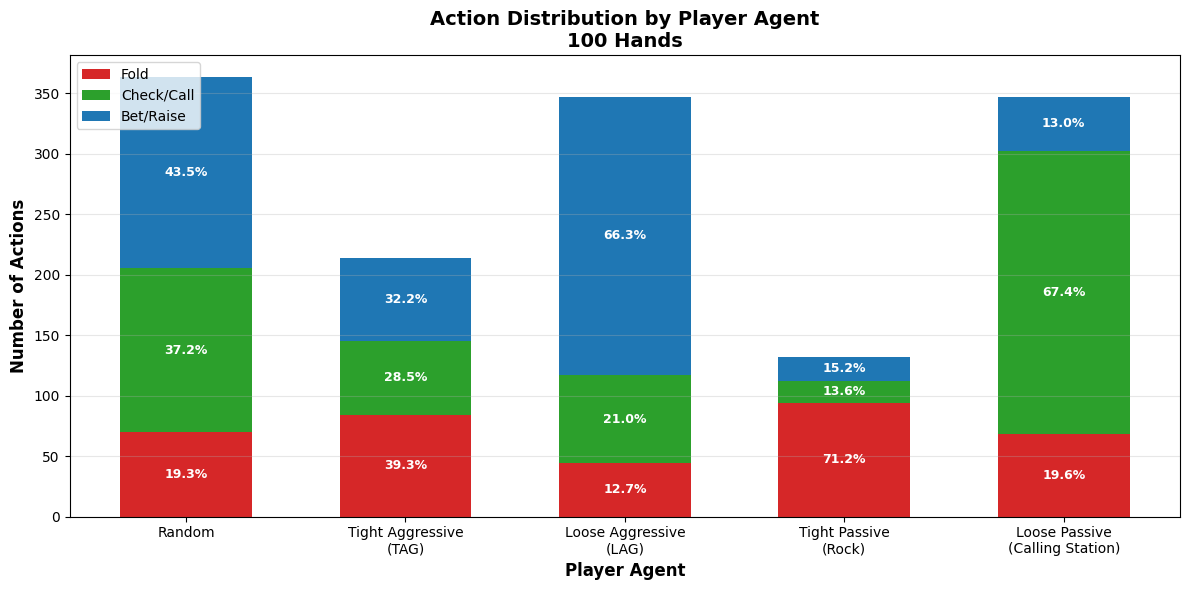

In [13]:
player_names = [
        "Random",
        "Tight Aggressive\n(TAG)",
        "Loose Aggressive\n(LAG)",
        "Tight Passive\n(Rock)",
        "Loose Passive\n(Calling Station)",
    ]
plot_actions_taken(actions_taken, player_names)

In [14]:
def plot_cumulative_rewards(
    rewards_over_time: list[list[int]], player_names: list[str]
) -> None:
    # Claude 4.5 prompt: Visualize cumulative profit/loss over time for each player
    fig, ax = plt.subplots(figsize=(14, 7))

    # Calculate cumulative rewards for each player
    cumulative_rewards = []
    for player_rewards in rewards_over_time:
        cumulative = np.cumsum(player_rewards)
        cumulative_rewards.append(cumulative)

    # Plot cumulative rewards for each player
    colors = ["#e74c3c", "#3498db", "#2ecc71", "#f39c12", "#9b59b6"]
    for i, (player_name, cumulative_reward, color) in enumerate(
        zip(player_names, cumulative_rewards, colors)
    ):
        ax.plot(
            range(len(cumulative_reward)),
            cumulative_reward,
            label=player_name,
            color=color,
            linewidth=2.5,
            alpha=0.8,
        )

    # Add horizontal line at y=0 to show break-even
    ax.axhline(
        y=0, color="black", linestyle="--", linewidth=1, alpha=0.5, label="Break Even"
    )

    # Customize the chart
    ax.set_xlabel("Hand Number", fontsize=12, fontweight="bold")
    ax.set_ylabel("Cumulative Profit/Loss (chips)", fontsize=12, fontweight="bold")
    ax.set_title(
        f"Player Performance Over {num_hands} Hands\n(Starting Stack: {starting_stack} chips)",
        fontsize=14,
        fontweight="bold",
    )
    ax.legend(loc="best", fontsize=10)
    ax.grid(True, alpha=0.3)

    # Add final profit/loss annotation for each player
    for i, (player_name, cumulative_reward, color) in enumerate(
        zip(player_names, cumulative_rewards, colors)
    ):
        final_profit = cumulative_reward[-1]
        ax.annotate(
            f"{final_profit:+d}",
            xy=(len(cumulative_reward) - 1, final_profit),
            xytext=(10, 0),
            textcoords="offset points",
            fontsize=9,
            fontweight="bold",
            color=color,
            bbox=dict(
                boxstyle="round,pad=0.3", facecolor="white", edgecolor=color, alpha=0.8
            ),
        )

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n" + "=" * 70)
    print("FINAL RESULTS SUMMARY")
    print("=" * 70)
    print(f"Starting stack: {starting_stack:,} chips\n")
    for i, (player_name, player) in enumerate(zip(player_names, players)):
        final_stack = player.stack
        profit_loss = final_stack - starting_stack
        profit_pct = (profit_loss / starting_stack) * 100
        print(
            f"{player_name:<30} | Final: {final_stack:,} | P/L: {profit_loss:+,} ({profit_pct:+.2f}%)"
        )
    print("=" * 70)

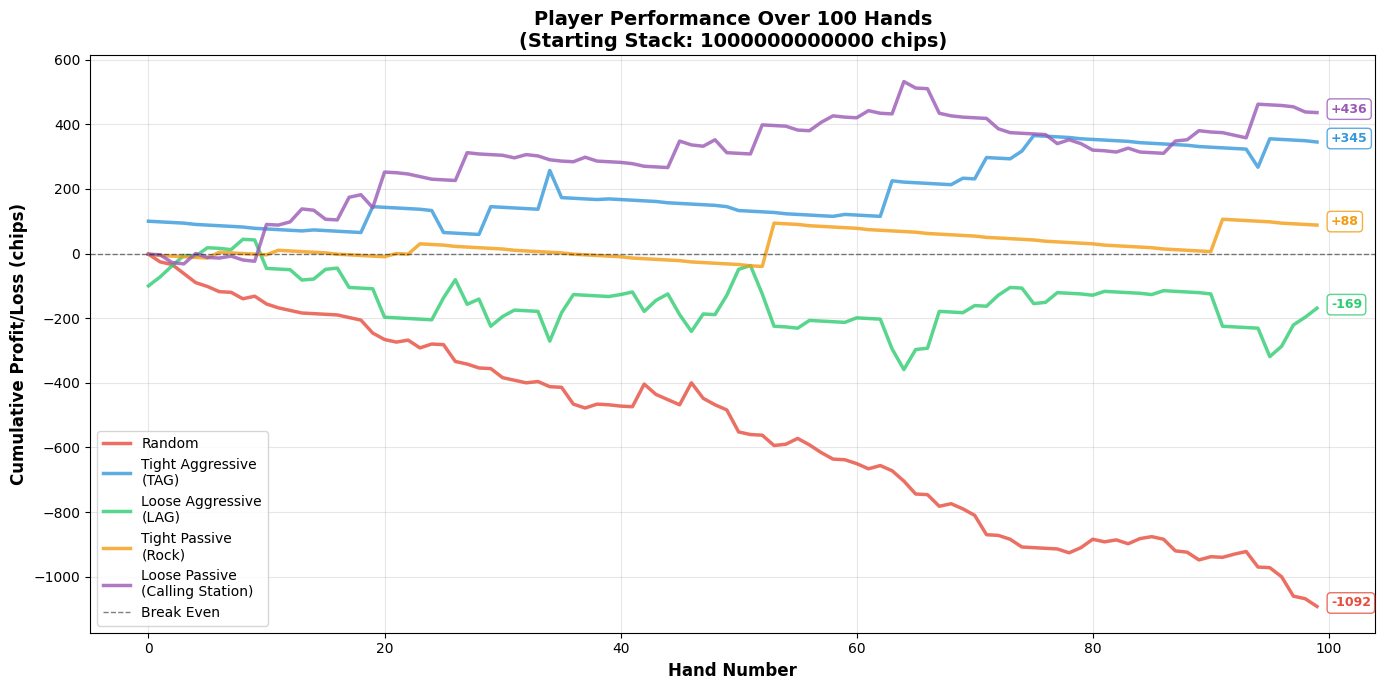


FINAL RESULTS SUMMARY
Starting stack: 1,000,000,000,000 chips

Random                         | Final: 999,999,998,938 | P/L: -1,062 (-0.00%)
Tight Aggressive
(TAG)         | Final: 1,000,000,000,461 | P/L: +461 (+0.00%)
Loose Aggressive
(LAG)         | Final: 999,999,999,897 | P/L: -103 (-0.00%)
Tight Passive
(Rock)           | Final: 1,000,000,000,204 | P/L: +204 (+0.00%)
Loose Passive
(Calling Station) | Final: 1,000,000,000,500 | P/L: +500 (+0.00%)


In [15]:
plot_cumulative_rewards(rewards_over_time, player_names)

## Evolutionary Agent Base Class

This class will be inherited by both our single- and multi-objective evolutionary agents. It contains shared methods for encoding the observation vector (φ), decoding our parameter vector (θ), 

In [16]:
class EvolutionaryPokerAgent(PokerAgent):
    """
    A abstract evolutionary agent class to handle the encoding/decoding
    of the parameter vector θ which is also our chromosome for learning.

    This base class contains the method for encoding the observation vector,
    φ, a method to decode θ into weights and biases, and a simple softmax
    implementation (which I know is in scipy but it is simple enough to avoid the
    extra dependency).
    """

    def __init__(
        self,
    ) -> None:
        super().__init__()

        # hand_strength, scaled_pot_size, pot_odds, checking_or_calling_amount,
        # min_completion_betting_or_raising_to_amount,
        # street (one-hot encoded): is_pre_flop, is_flop, is_turn, is_river
        self.N_FEATURES = 9

        # fold, check/call, bet/raise
        self.N_ACTIONS = 3

    def encode_observation_vector(self, observation: ObservableState) -> np.ndarray:
        """Encodes the observation into a vector (φ)."""
        # one-hot encode the street
        encoded_street = np.zeros(4)
        encoded_street[observation.street.value] = 1

        # Handle None values from pokerkit - set to 0 when action is unavailable
        checking_or_calling_amount = (
            observation.checking_or_calling_amount
            if observation.checking_or_calling_amount is not None
            else 0
        )
        min_completion_betting_or_raising_to_amount = (
            observation.min_completion_betting_or_raising_to_amount
            if observation.min_completion_betting_or_raising_to_amount is not None
            else 0
        )

        big_bet = 8.0  # Fixed limit big bet size
        pot_in_bets = observation.pot_size / big_bet

        # ChatGPT recommendation - prompt: My evolutionary agent learns to always call. Here is the learning output
        # Should I run for more generations or more hands per evaluation or look at something else. It suggested
        # normalizing my features.
        scaled_pot = np.tanh(pot_in_bets / 10.0)
        pot_odds = checking_or_calling_amount / (
            observation.pot_size + checking_or_calling_amount + 1e-6
        )

        φ = np.array(
            [
                observation.hand_strength,  # Already between 0 and 1
                scaled_pot,  # Normalized pot size using big bet an tanh
                pot_odds,  # Pot odds for checking or calling
                checking_or_calling_amount / big_bet,  # Normalize using the big bet
                min_completion_betting_or_raising_to_amount
                / big_bet,  # Normalize using the big bet
                *encoded_street,
            ]
        )
        return φ

    def decode_theta(self, θ: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        """ChatGPT 5.1 prompt: Decode theta for N_FEATURES and N_ACTIONS."""
        θ = np.asarray(θ, dtype=float)
        W = θ[: self.N_FEATURES * self.N_ACTIONS].reshape(
            self.N_ACTIONS, self.N_FEATURES
        )
        b = θ[self.N_FEATURES * self.N_ACTIONS :]
        return W, b

    @staticmethod
    def softmax(logits: np.ndarray, mask: np.ndarray) -> np.ndarray:
        # Claude 4.5: tab-complete after typing the method signature

        # This masks off actions that aren't available
        masked_logits = np.where(mask, logits, -np.inf)

        # Take a softmax over the available actions
        max_logit = np.max(masked_logits)
        exp_logits = np.exp(masked_logits - max_logit)
        return exp_logits / exp_logits.sum(axis=0)

## Single-Objective Evolutionary Agent

In the following section, I will create and train, via an evolutionary algorithm, a poker player with the sole objective of maximizing rewards (winnings) against the other player types.

In [17]:
class AgentEvolutionarySingleObjective(EvolutionaryPokerAgent):
    """
    A poker agent that uses a single-objective evolutionary algorithm
    to learn its _sole_ policy's parameters.
    """

    def π(self, observation: ObservableState, θ: np.ndarray, **kwargs) -> ActionType:
        if θ is None:
            raise ValueError("θ must be provided for the evolutionary agent.")
        W, b = self.decode_theta(θ)
        φ = self.encode_observation_vector(observation)
        logits = W @ φ + b

        # Create a mask for available actions
        mask = np.array(
            [
                observation.can_fold,
                observation.can_check_or_call,
                observation.can_complete_bet_or_raise_to,
            ],
            dtype=bool,
        )

        action_probs = self.softmax(logits, mask=mask)
        action_index = np.random.choice(range(len(action_probs)), p=action_probs)
        action = ActionType(action_index)
        if (
            action == ActionType.FOLD
            and observation.can_check_or_call
            and observation.checking_or_calling_amount == 0
        ):
            action = (
                ActionType.CHECK_OR_CALL
            )  # avoid folding when we can check for free
        return action

## Configure Environment for Single-Objective Evolutionary Agent

The following environment is configured with the single-objective evolutionary agent against the four coded playing types.

In [18]:
player_0 = PokerPlayer(
    poker_agent=AgentEvolutionarySingleObjective(), player_index=0, stack=starting_stack
)
player_1 = PokerPlayer(
    poker_agent=AgentTightAggressive(), player_index=1, stack=starting_stack
)
player_2 = PokerPlayer(
    poker_agent=AgentLooseAggressive(), player_index=2, stack=starting_stack
)
player_3 = PokerPlayer(
    poker_agent=AgentTightPassive(), player_index=3, stack=starting_stack
)
player_4 = PokerPlayer(
    poker_agent=AgentLoosePassive(), player_index=4, stack=starting_stack
)
players = [player_0, player_1, player_2, player_3, player_4]

single_objective_env = FixedLimitTexasHoldemEnvironment(players=players)

## Single-Objective Fitness Function

The following fitness function will be used to evaluate our parameter vector (θ) by playing several hands of poker and returning the average reward.

In [19]:
def fitness_single_objective(
    θ: np.ndarray,
) -> tuple[float]:
    """
    Claude 4.5 prompt: I tab completed the docstring after typing the method signature.
    Fitness function for single-objective evolutionary poker agent.

    Plays multiple hands and returns average profit as fitness.
    Args:
        θ (np.ndarray): The parameter vector for the evolutionary agent.
    Returns:
        tuple[float]: The average profit as fitness.
    """
    num_hands = 100
    total_reward = 0.0

    for _ in tqdm(range(num_hands), desc="Evaluating fitness..."):
        rewards = play_one_hand_of_poker(
            env=single_objective_env,
            players=players,
            actions_taken=[[] for _ in players],  # No need to track actions here
            θ=θ,
        )
        total_reward += rewards[0]  # Reward for the evolutionary agent
    average_reward = total_reward / num_hands
    return (average_reward,)

## Configure Evolutionary Algorithm for Single-Objective Learning

In [20]:
# maximize fitness
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# register a tool to generate candidate solutions
toolbox.register("attr_float", random.gauss, 0.0, 1.0)

# Should be 9 * 3 + 3 = 30 for our chromosome size
chromosome_size = (
    player_0.poker_agent.N_FEATURES * player_0.poker_agent.N_ACTIONS
    + player_0.poker_agent.N_ACTIONS
)
assert chromosome_size == 30, f"Expected chromosome size 30 but got {chromosome_size}"

toolbox.register(
    "individual",
    tools.initRepeat,
    creator.Individual,
    toolbox.attr_float,
    n=chromosome_size,
)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# register our evaluation/fitness function
toolbox.register("evaluate", fitness_single_objective)

# register our crossover/mating operator
toolbox.register("mate", tools.cxTwoPoint)

# define the mutation parameters and register the mutation operator
sigma = 0.1  # standard deviation for the Gaussian mutation
mutation_probability = 0.2  # probability of mutation

toolbox.register(
    "mutate",
    tools.mutGaussian,  # Gaussian mutation adds noise from the Gaussian/normal distribution
    mu=0.0,
    sigma=sigma,
    indpb=mutation_probability,
)

# use a tournament to select candidates for mating
toolbox.register("select", tools.selTournament, tournsize=3)

# use multiprocessing - doesn't work in notebooks
# pool = Pool()
# toolbox.register("map", pool.map)

In [21]:
LOAD_BEST_THETA_SINGLE_OBJECTIVE = (
    True  # Set to False to rerun the evolution, True loads the best θ from a file.
)

if LOAD_BEST_THETA_SINGLE_OBJECTIVE:
    best_theta_single_objective = np.load("best_theta_single_objective.npy")
    print(f"Loaded best_theta with shape: {best_theta_single_objective.shape}")
else:
    POPULATION_SIZE = 100
    NUM_GENERATIONS = 50
    CROSSOVER_PROBABILITY = 0.50
    MUTATION_PROBABILITY = 0.3

    # Initialize the population
    pop = toolbox.population(n=POPULATION_SIZE)

    # Configure statistics
    stats = tools.Statistics(lambda ind: ind.fitness.values[0])
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # Keep track of the single best individual
    hof = tools.HallOfFame(1)

    # Run the evolutionary algorithm
    pop, logbook = algorithms.eaSimple(
        population=pop,
        toolbox=toolbox,
        cxpb=CROSSOVER_PROBABILITY,
        mutpb=MUTATION_PROBABILITY,
        ngen=NUM_GENERATIONS,
        stats=stats,
        halloffame=hof,
        verbose=True,
    )

    # Collect our best performing individual
    best_theta_single_objective = np.array(hof[0], dtype=float)
    print("Best fitness:", hof[0].fitness.values[0])

Loaded best_theta with shape: (30,)


In [22]:
# Delete the creator attributes so the code can re-enter without warning
if "FitnessMax" in dir(creator):
    del creator.FitnessMax
if "Individual" in dir(creator):
    del creator.Individual

In [23]:
# Save the best theta to skip re-training later
if not LOAD_BEST_THETA_SINGLE_OBJECTIVE:
    np.save("best_theta_single_objective.npy", best_theta_single_objective)
print("Best theta - single objective:", best_theta_single_objective)

Best theta - single objective: [-1.60360182 -1.01591572 -2.63880894  0.93565279  1.79396618  1.32958545
  0.22664857  2.3298545   0.99032711 -0.63844167 -0.69498631  1.02208298
 -0.6265226  -0.09917906  0.14128726 -1.88855749  0.06896655  0.29458549
  0.6813594  -0.10489241  0.91130122 -1.2720451   0.1688433   0.18959133
 -0.05219483  0.03176999 -0.10916638  1.27735592 -1.27452051 -0.64489971]


## Single-Objective (best θ) against the other agents.

In this section, I will let the single-objective evolutionary agent compete against the other coded agents.

In [24]:
starting_stack = int(1e12)  # Start high to avoid going bankrupt
player_0 = PokerPlayer(poker_agent=AgentEvolutionarySingleObjective(), player_index=0, stack=starting_stack)
player_1 = PokerPlayer(
    poker_agent=AgentTightAggressive(), player_index=1, stack=starting_stack
)
player_2 = PokerPlayer(
    poker_agent=AgentLooseAggressive(), player_index=2, stack=starting_stack
)
player_3 = PokerPlayer(
    poker_agent=AgentTightPassive(), player_index=3, stack=starting_stack
)
player_4 = PokerPlayer(
    poker_agent=AgentLoosePassive(), player_index=4, stack=starting_stack
)
players = [player_0, player_1, player_2, player_3, player_4]
actions_taken = [[] for _ in players]
rewards_over_time = [[] for _ in players]

env = FixedLimitTexasHoldemEnvironment(players=players)
num_hands = 100

for hand in tqdm(
    range(num_hands), desc="Playing hands with single-objective agent vs. coded agents."
):
    rewards = play_one_hand_of_poker(
        env=env,
        players=players,
        actions_taken=actions_taken,
        θ=best_theta_single_objective,
    )

    # Save the rewards for graphing later
    for i, reward in enumerate(rewards):
        rewards_over_time[i].append(reward)

    print(f"Completed hand {hand}.")
    print(f"Player stacks: {[player.stack for player in players]}")

Playing hands with single-objective agent vs. coded agents.:   1%|          | 1/100 [00:00<01:38,  1.01it/s]

Completed hand 0.
Player stacks: [1000000000000, 999999999998, 1000000000022, 1000000000000, 999999999980]


Playing hands with single-objective agent vs. coded agents.:   2%|▏         | 2/100 [00:01<01:11,  1.37it/s]

Completed hand 1.
Player stacks: [1000000000000, 999999999998, 1000000000020, 1000000000050, 999999999932]


Playing hands with single-objective agent vs. coded agents.:   3%|▎         | 3/100 [00:01<00:53,  1.81it/s]

Completed hand 2.
Player stacks: [1000000000000, 999999999998, 1000000000030, 1000000000048, 999999999924]


Playing hands with single-objective agent vs. coded agents.:   4%|▍         | 4/100 [00:02<00:46,  2.07it/s]

Completed hand 3.
Player stacks: [1000000000020, 999999999998, 1000000000030, 1000000000048, 999999999904]


Playing hands with single-objective agent vs. coded agents.:   5%|▌         | 5/100 [00:02<00:42,  2.22it/s]

Completed hand 4.
Player stacks: [1000000000018, 1000000000072, 1000000000030, 1000000000048, 999999999832]


Playing hands with single-objective agent vs. coded agents.:   6%|▌         | 6/100 [00:03<00:47,  1.99it/s]

Completed hand 5.
Player stacks: [1000000000018, 1000000000248, 999999999942, 1000000000048, 999999999744]


Playing hands with single-objective agent vs. coded agents.:   7%|▋         | 7/100 [00:03<00:37,  2.45it/s]

Completed hand 6.
Player stacks: [1000000000018, 1000000000248, 999999999946, 1000000000044, 999999999744]


Playing hands with single-objective agent vs. coded agents.:   8%|▊         | 8/100 [00:03<00:38,  2.40it/s]

Completed hand 7.
Player stacks: [1000000000018, 1000000000248, 999999999960, 1000000000042, 999999999732]


Playing hands with single-objective agent vs. coded agents.:   9%|▉         | 9/100 [00:04<00:39,  2.29it/s]

Completed hand 8.
Player stacks: [1000000000026, 1000000000248, 999999999960, 1000000000042, 999999999724]


Playing hands with single-objective agent vs. coded agents.:  11%|█         | 11/100 [00:05<00:35,  2.50it/s]

Completed hand 9.
Player stacks: [1000000000024, 1000000000232, 999999999936, 1000000000042, 999999999766]
Completed hand 10.
Player stacks: [1000000000024, 1000000000230, 999999999938, 1000000000042, 999999999766]


Playing hands with single-objective agent vs. coded agents.:  12%|█▏        | 12/100 [00:05<00:37,  2.35it/s]

Completed hand 11.
Player stacks: [1000000000024, 1000000000230, 999999999874, 1000000000038, 999999999834]


Playing hands with single-objective agent vs. coded agents.:  13%|█▎        | 13/100 [00:05<00:31,  2.79it/s]

Completed hand 12.
Player stacks: [1000000000024, 1000000000230, 999999999874, 1000000000036, 999999999836]


Playing hands with single-objective agent vs. coded agents.:  14%|█▍        | 14/100 [00:06<00:35,  2.43it/s]

Completed hand 13.
Player stacks: [1000000000016, 1000000000230, 999999999842, 1000000000036, 999999999876]


Playing hands with single-objective agent vs. coded agents.:  15%|█▌        | 15/100 [00:06<00:35,  2.40it/s]

Completed hand 14.
Player stacks: [1000000000014, 1000000000240, 999999999842, 1000000000036, 999999999868]


Playing hands with single-objective agent vs. coded agents.:  16%|█▌        | 16/100 [00:07<00:42,  1.99it/s]

Completed hand 15.
Player stacks: [1000000000014, 1000000000164, 999999999918, 1000000000036, 999999999868]


Playing hands with single-objective agent vs. coded agents.:  17%|█▋        | 17/100 [00:07<00:37,  2.24it/s]

Completed hand 16.
Player stacks: [1000000000014, 1000000000170, 999999999916, 1000000000032, 999999999868]


Playing hands with single-objective agent vs. coded agents.:  18%|█▊        | 18/100 [00:08<00:35,  2.32it/s]

Completed hand 17.
Player stacks: [1000000000014, 1000000000176, 999999999916, 1000000000030, 999999999864]


Playing hands with single-objective agent vs. coded agents.:  19%|█▉        | 19/100 [00:08<00:38,  2.10it/s]

Completed hand 18.
Player stacks: [1000000000042, 1000000000176, 999999999916, 1000000000030, 999999999836]


Playing hands with single-objective agent vs. coded agents.:  20%|██        | 20/100 [00:09<00:40,  1.95it/s]

Completed hand 19.
Player stacks: [1000000000040, 1000000000172, 999999999916, 1000000000030, 999999999842]


Playing hands with single-objective agent vs. coded agents.:  21%|██        | 21/100 [00:10<00:48,  1.64it/s]

Completed hand 20.
Player stacks: [1000000000040, 1000000000084, 1000000000012, 1000000000030, 999999999834]


Playing hands with single-objective agent vs. coded agents.:  22%|██▏       | 22/100 [00:10<00:49,  1.56it/s]

Completed hand 21.
Player stacks: [1000000000040, 1000000000012, 1000000000156, 999999999958, 999999999834]


Playing hands with single-objective agent vs. coded agents.:  23%|██▎       | 23/100 [00:11<00:47,  1.63it/s]

Completed hand 22.
Player stacks: [1000000000028, 1000000000012, 1000000000156, 999999999978, 999999999826]


Playing hands with single-objective agent vs. coded agents.:  24%|██▍       | 24/100 [00:11<00:42,  1.81it/s]

Completed hand 23.
Player stacks: [1000000000008, 1000000000012, 1000000000156, 999999999978, 999999999846]


Playing hands with single-objective agent vs. coded agents.:  25%|██▌       | 25/100 [00:12<00:38,  1.97it/s]

Completed hand 24.
Player stacks: [1000000000006, 1000000000008, 1000000000156, 999999999978, 999999999852]


Playing hands with single-objective agent vs. coded agents.:  26%|██▌       | 26/100 [00:12<00:35,  2.10it/s]

Completed hand 25.
Player stacks: [1000000000006, 1000000000096, 1000000000068, 999999999978, 999999999852]


Playing hands with single-objective agent vs. coded agents.:  27%|██▋       | 27/100 [00:13<00:33,  2.17it/s]

Completed hand 26.
Player stacks: [1000000000006, 1000000000104, 1000000000064, 999999999974, 999999999852]


Playing hands with single-objective agent vs. coded agents.:  28%|██▊       | 28/100 [00:13<00:32,  2.23it/s]

Completed hand 27.
Player stacks: [1000000000006, 1000000000104, 1000000000070, 999999999972, 999999999848]


Playing hands with single-objective agent vs. coded agents.:  29%|██▉       | 29/100 [00:14<00:33,  2.09it/s]

Completed hand 28.
Player stacks: [999999999998, 1000000000104, 1000000000018, 999999999972, 999999999908]


Playing hands with single-objective agent vs. coded agents.:  30%|███       | 30/100 [00:14<00:33,  2.07it/s]

Completed hand 29.
Player stacks: [999999999996, 1000000000105, 1000000000018, 999999999972, 999999999909]


Playing hands with single-objective agent vs. coded agents.:  31%|███       | 31/100 [00:15<00:31,  2.20it/s]

Completed hand 30.
Player stacks: [999999999996, 1000000000193, 999999999930, 999999999972, 999999999909]


Playing hands with single-objective agent vs. coded agents.:  32%|███▏      | 32/100 [00:15<00:25,  2.64it/s]

Completed hand 31.
Player stacks: [999999999996, 1000000000193, 999999999934, 999999999968, 999999999909]


Playing hands with single-objective agent vs. coded agents.:  33%|███▎      | 33/100 [00:15<00:25,  2.60it/s]

Completed hand 32.
Player stacks: [999999999996, 1000000000193, 999999999882, 999999999966, 999999999963]


Playing hands with single-objective agent vs. coded agents.:  34%|███▍      | 34/100 [00:15<00:23,  2.83it/s]

Completed hand 33.
Player stacks: [1000000000004, 1000000000193, 999999999882, 999999999966, 999999999955]


Playing hands with single-objective agent vs. coded agents.:  35%|███▌      | 35/100 [00:16<00:24,  2.69it/s]

Completed hand 34.
Player stacks: [1000000000002, 1000000000199, 999999999882, 999999999966, 999999999951]


Playing hands with single-objective agent vs. coded agents.:  36%|███▌      | 36/100 [00:16<00:26,  2.41it/s]

Completed hand 35.
Player stacks: [1000000000002, 1000000000299, 999999999782, 999999999966, 999999999951]


Playing hands with single-objective agent vs. coded agents.:  37%|███▋      | 37/100 [00:17<00:25,  2.44it/s]

Completed hand 36.
Player stacks: [1000000000002, 1000000000299, 999999999774, 999999999974, 999999999951]


Playing hands with single-objective agent vs. coded agents.:  38%|███▊      | 38/100 [00:17<00:23,  2.68it/s]

Completed hand 37.
Player stacks: [1000000000002, 1000000000299, 999999999784, 999999999972, 999999999943]


Playing hands with single-objective agent vs. coded agents.:  39%|███▉      | 39/100 [00:17<00:23,  2.54it/s]

Completed hand 38.
Player stacks: [999999999982, 1000000000299, 999999999784, 999999999972, 999999999963]


Playing hands with single-objective agent vs. coded agents.:  41%|████      | 41/100 [00:18<00:17,  3.29it/s]

Completed hand 39.
Player stacks: [999999999980, 1000000000305, 999999999784, 999999999972, 999999999959]
Completed hand 40.
Player stacks: [999999999980, 1000000000303, 999999999786, 999999999972, 999999999959]


Playing hands with single-objective agent vs. coded agents.:  42%|████▏     | 42/100 [00:18<00:15,  3.83it/s]

Completed hand 41.
Player stacks: [999999999980, 1000000000303, 999999999790, 999999999968, 999999999959]


Playing hands with single-objective agent vs. coded agents.:  43%|████▎     | 43/100 [00:18<00:15,  3.65it/s]

Completed hand 42.
Player stacks: [999999999980, 1000000000303, 999999999800, 999999999966, 999999999951]


Playing hands with single-objective agent vs. coded agents.:  44%|████▍     | 44/100 [00:19<00:14,  3.80it/s]

Completed hand 43.
Player stacks: [999999999976, 1000000000303, 999999999806, 999999999966, 999999999949]


Playing hands with single-objective agent vs. coded agents.:  45%|████▌     | 45/100 [00:19<00:16,  3.30it/s]

Completed hand 44.
Player stacks: [999999999974, 1000000000259, 999999999806, 999999999966, 999999999995]


Playing hands with single-objective agent vs. coded agents.:  47%|████▋     | 47/100 [00:20<00:15,  3.43it/s]

Completed hand 45.
Player stacks: [999999999974, 1000000000239, 999999999826, 999999999966, 999999999995]
Completed hand 46.
Player stacks: [999999999974, 1000000000239, 999999999830, 999999999962, 999999999995]


Playing hands with single-objective agent vs. coded agents.:  48%|████▊     | 48/100 [00:20<00:16,  3.08it/s]

Completed hand 47.
Player stacks: [999999999974, 1000000000239, 999999999770, 999999999960, 1000000000057]


Playing hands with single-objective agent vs. coded agents.:  49%|████▉     | 49/100 [00:20<00:16,  3.05it/s]

Completed hand 48.
Player stacks: [999999999986, 1000000000239, 999999999770, 999999999960, 1000000000045]


Playing hands with single-objective agent vs. coded agents.:  51%|█████     | 51/100 [00:21<00:14,  3.37it/s]

Completed hand 49.
Player stacks: [999999999984, 1000000000245, 999999999770, 999999999960, 1000000000041]
Completed hand 50.
Player stacks: [999999999976, 1000000000243, 999999999780, 999999999960, 1000000000041]


Playing hands with single-objective agent vs. coded agents.:  52%|█████▏    | 52/100 [00:21<00:13,  3.67it/s]

Completed hand 51.
Player stacks: [999999999976, 1000000000243, 999999999784, 999999999956, 1000000000041]


Playing hands with single-objective agent vs. coded agents.:  53%|█████▎    | 53/100 [00:21<00:12,  3.62it/s]

Completed hand 52.
Player stacks: [999999999976, 1000000000243, 999999999794, 999999999954, 1000000000033]


Playing hands with single-objective agent vs. coded agents.:  54%|█████▍    | 54/100 [00:22<00:12,  3.64it/s]

Completed hand 53.
Player stacks: [999999999984, 1000000000243, 999999999794, 999999999954, 1000000000025]


Playing hands with single-objective agent vs. coded agents.:  55%|█████▌    | 55/100 [00:22<00:13,  3.24it/s]

Completed hand 54.
Player stacks: [999999999960, 1000000000267, 999999999794, 999999999954, 1000000000025]


Playing hands with single-objective agent vs. coded agents.:  56%|█████▌    | 56/100 [00:22<00:14,  3.02it/s]

Completed hand 55.
Player stacks: [999999999960, 1000000000167, 999999999894, 999999999954, 1000000000025]


Playing hands with single-objective agent vs. coded agents.:  57%|█████▋    | 57/100 [00:23<00:13,  3.18it/s]

Completed hand 56.
Player stacks: [999999999960, 1000000000167, 999999999906, 999999999942, 1000000000025]


Playing hands with single-objective agent vs. coded agents.:  58%|█████▊    | 58/100 [00:23<00:13,  3.01it/s]

Completed hand 57.
Player stacks: [999999999932, 1000000000167, 999999999906, 999999999940, 1000000000055]


Playing hands with single-objective agent vs. coded agents.:  59%|█████▉    | 59/100 [00:24<00:16,  2.45it/s]

Completed hand 58.
Player stacks: [999999999924, 1000000000167, 999999999902, 999999999940, 1000000000067]


Playing hands with single-objective agent vs. coded agents.:  60%|██████    | 60/100 [00:24<00:14,  2.67it/s]

Completed hand 59.
Player stacks: [999999999922, 1000000000177, 999999999902, 999999999940, 1000000000059]


Playing hands with single-objective agent vs. coded agents.:  62%|██████▏   | 62/100 [00:25<00:12,  3.01it/s]

Completed hand 60.
Player stacks: [999999999922, 1000000000175, 999999999894, 999999999940, 1000000000069]
Completed hand 61.
Player stacks: [999999999922, 1000000000175, 999999999898, 999999999936, 1000000000069]


Playing hands with single-objective agent vs. coded agents.:  63%|██████▎   | 63/100 [00:25<00:11,  3.20it/s]

Completed hand 62.
Player stacks: [999999999922, 1000000000175, 999999999904, 999999999934, 1000000000065]


Playing hands with single-objective agent vs. coded agents.:  64%|██████▍   | 64/100 [00:25<00:11,  3.12it/s]

Completed hand 63.
Player stacks: [999999999930, 1000000000175, 999999999900, 999999999934, 1000000000061]


Playing hands with single-objective agent vs. coded agents.:  65%|██████▌   | 65/100 [00:26<00:12,  2.86it/s]

Completed hand 64.
Player stacks: [999999999928, 1000000000155, 999999999922, 999999999934, 1000000000061]


Playing hands with single-objective agent vs. coded agents.:  66%|██████▌   | 66/100 [00:26<00:14,  2.41it/s]

Completed hand 65.
Player stacks: [999999999928, 1000000000163, 999999999918, 999999999934, 1000000000057]


Playing hands with single-objective agent vs. coded agents.:  67%|██████▋   | 67/100 [00:27<00:13,  2.38it/s]

Completed hand 66.
Player stacks: [999999999928, 1000000000163, 999999999830, 1000000000022, 1000000000057]


Playing hands with single-objective agent vs. coded agents.:  68%|██████▊   | 68/100 [00:27<00:12,  2.51it/s]

Completed hand 67.
Player stacks: [999999999928, 1000000000163, 999999999840, 1000000000020, 1000000000049]


Playing hands with single-objective agent vs. coded agents.:  70%|███████   | 70/100 [00:27<00:08,  3.37it/s]

Completed hand 68.
Player stacks: [999999999924, 1000000000163, 999999999846, 1000000000020, 1000000000047]
Completed hand 69.
Player stacks: [999999999916, 1000000000171, 999999999846, 1000000000020, 1000000000047]


Playing hands with single-objective agent vs. coded agents.:  71%|███████   | 71/100 [00:28<00:10,  2.70it/s]

Completed hand 70.
Player stacks: [999999999916, 1000000000169, 999999999856, 1000000000020, 1000000000039]


Playing hands with single-objective agent vs. coded agents.:  72%|███████▏  | 72/100 [00:28<00:10,  2.65it/s]

Completed hand 71.
Player stacks: [999999999916, 1000000000169, 999999999944, 999999999932, 1000000000039]


Playing hands with single-objective agent vs. coded agents.:  73%|███████▎  | 73/100 [00:29<00:10,  2.64it/s]

Completed hand 72.
Player stacks: [999999999916, 1000000000169, 999999999944, 999999999928, 1000000000043]


Playing hands with single-objective agent vs. coded agents.:  74%|███████▍  | 74/100 [00:29<00:10,  2.58it/s]

Completed hand 73.
Player stacks: [999999999896, 1000000000169, 999999999944, 999999999928, 1000000000063]


Playing hands with single-objective agent vs. coded agents.:  75%|███████▌  | 75/100 [00:30<00:11,  2.23it/s]

Completed hand 74.
Player stacks: [999999999894, 1000000000175, 999999999944, 999999999928, 1000000000059]


Playing hands with single-objective agent vs. coded agents.:  77%|███████▋  | 77/100 [00:31<00:09,  2.50it/s]

Completed hand 75.
Player stacks: [999999999894, 1000000000143, 999999999980, 999999999928, 1000000000055]
Completed hand 76.
Player stacks: [999999999894, 1000000000143, 999999999984, 999999999924, 1000000000055]


Playing hands with single-objective agent vs. coded agents.:  78%|███████▊  | 78/100 [00:31<00:09,  2.41it/s]

Completed hand 77.
Player stacks: [999999999894, 1000000000143, 999999999956, 999999999922, 1000000000085]


Playing hands with single-objective agent vs. coded agents.:  79%|███████▉  | 79/100 [00:31<00:08,  2.41it/s]

Completed hand 78.
Player stacks: [999999999874, 1000000000143, 999999999956, 999999999922, 1000000000105]


Playing hands with single-objective agent vs. coded agents.:  80%|████████  | 80/100 [00:32<00:07,  2.61it/s]

Completed hand 79.
Player stacks: [999999999872, 1000000000149, 999999999956, 999999999922, 1000000000101]


Playing hands with single-objective agent vs. coded agents.:  81%|████████  | 81/100 [00:32<00:06,  2.72it/s]

Completed hand 80.
Player stacks: [999999999872, 1000000000147, 999999999966, 999999999922, 1000000000093]


Playing hands with single-objective agent vs. coded agents.:  82%|████████▏ | 82/100 [00:32<00:06,  2.67it/s]

Completed hand 81.
Player stacks: [999999999872, 1000000000147, 999999999878, 1000000000010, 1000000000093]


Playing hands with single-objective agent vs. coded agents.:  83%|████████▎ | 83/100 [00:33<00:06,  2.63it/s]

Completed hand 82.
Player stacks: [999999999872, 1000000000147, 999999999850, 1000000000008, 1000000000123]


Playing hands with single-objective agent vs. coded agents.:  84%|████████▍ | 84/100 [00:33<00:06,  2.33it/s]

Completed hand 83.
Player stacks: [999999999884, 1000000000147, 999999999850, 1000000000008, 1000000000111]


Playing hands with single-objective agent vs. coded agents.:  85%|████████▌ | 85/100 [00:34<00:05,  2.75it/s]

Completed hand 84.
Player stacks: [999999999882, 1000000000149, 999999999850, 1000000000008, 1000000000111]


Playing hands with single-objective agent vs. coded agents.:  86%|████████▌ | 86/100 [00:34<00:06,  2.32it/s]

Completed hand 85.
Player stacks: [999999999882, 1000000000225, 999999999774, 1000000000008, 1000000000111]


Playing hands with single-objective agent vs. coded agents.:  87%|████████▋ | 87/100 [00:35<00:06,  2.10it/s]

Completed hand 86.
Player stacks: [999999999882, 1000000000225, 999999999778, 1000000000004, 1000000000111]


Playing hands with single-objective agent vs. coded agents.:  88%|████████▊ | 88/100 [00:36<00:06,  1.73it/s]

Completed hand 87.
Player stacks: [999999999882, 1000000000225, 999999999750, 1000000000002, 1000000000141]


Playing hands with single-objective agent vs. coded agents.:  89%|████████▉ | 89/100 [00:36<00:06,  1.68it/s]

Completed hand 88.
Player stacks: [999999999874, 1000000000225, 999999999790, 1000000000002, 1000000000109]


Playing hands with single-objective agent vs. coded agents.:  90%|█████████ | 90/100 [00:37<00:06,  1.60it/s]

Completed hand 89.
Player stacks: [999999999872, 1000000000221, 999999999790, 1000000000002, 1000000000115]


Playing hands with single-objective agent vs. coded agents.:  91%|█████████ | 91/100 [00:37<00:05,  1.76it/s]

Completed hand 90.
Player stacks: [999999999872, 1000000000277, 999999999734, 1000000000002, 1000000000115]


Playing hands with single-objective agent vs. coded agents.:  92%|█████████▏| 92/100 [00:38<00:04,  1.98it/s]

Completed hand 91.
Player stacks: [999999999872, 1000000000277, 999999999742, 999999999994, 1000000000115]


Playing hands with single-objective agent vs. coded agents.:  93%|█████████▎| 93/100 [00:38<00:04,  1.70it/s]

Completed hand 92.
Player stacks: [999999999872, 1000000000277, 999999999756, 999999999992, 1000000000103]


Playing hands with single-objective agent vs. coded agents.:  94%|█████████▍| 94/100 [00:39<00:03,  1.73it/s]

Completed hand 93.
Player stacks: [999999999880, 1000000000277, 999999999756, 999999999992, 1000000000095]


Playing hands with single-objective agent vs. coded agents.:  95%|█████████▌| 95/100 [00:39<00:02,  1.94it/s]

Completed hand 94.
Player stacks: [999999999878, 1000000000279, 999999999756, 999999999992, 1000000000095]


Playing hands with single-objective agent vs. coded agents.:  96%|█████████▌| 96/100 [00:40<00:02,  1.88it/s]

Completed hand 95.
Player stacks: [999999999878, 1000000000279, 999999999756, 999999999992, 1000000000095]


Playing hands with single-objective agent vs. coded agents.:  97%|█████████▋| 97/100 [00:40<00:01,  2.17it/s]

Completed hand 96.
Player stacks: [999999999878, 1000000000279, 999999999760, 999999999988, 1000000000095]


Playing hands with single-objective agent vs. coded agents.:  98%|█████████▊| 98/100 [00:41<00:01,  1.87it/s]

Completed hand 97.
Player stacks: [999999999878, 1000000000279, 999999999672, 1000000000164, 1000000000007]


Playing hands with single-objective agent vs. coded agents.:  99%|█████████▉| 99/100 [00:41<00:00,  2.08it/s]

Completed hand 98.
Player stacks: [999999999886, 1000000000279, 999999999672, 1000000000164, 999999999999]


Playing hands with single-objective agent vs. coded agents.: 100%|██████████| 100/100 [00:42<00:00,  2.38it/s]

Completed hand 99.
Player stacks: [999999999878, 1000000000287, 999999999672, 1000000000164, 999999999999]


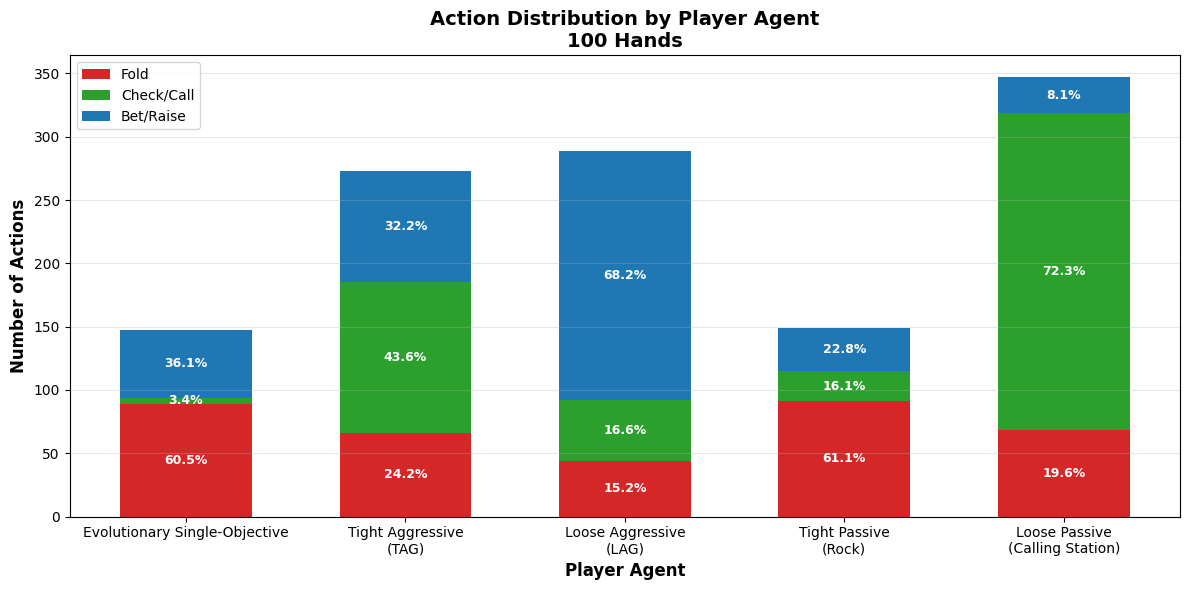

In [25]:
player_names = [
        "Evolutionary Single-Objective",
        "Tight Aggressive\n(TAG)",
        "Loose Aggressive\n(LAG)",
        "Tight Passive\n(Rock)",
        "Loose Passive\n(Calling Station)",
    ]
plot_actions_taken(actions_taken, player_names)

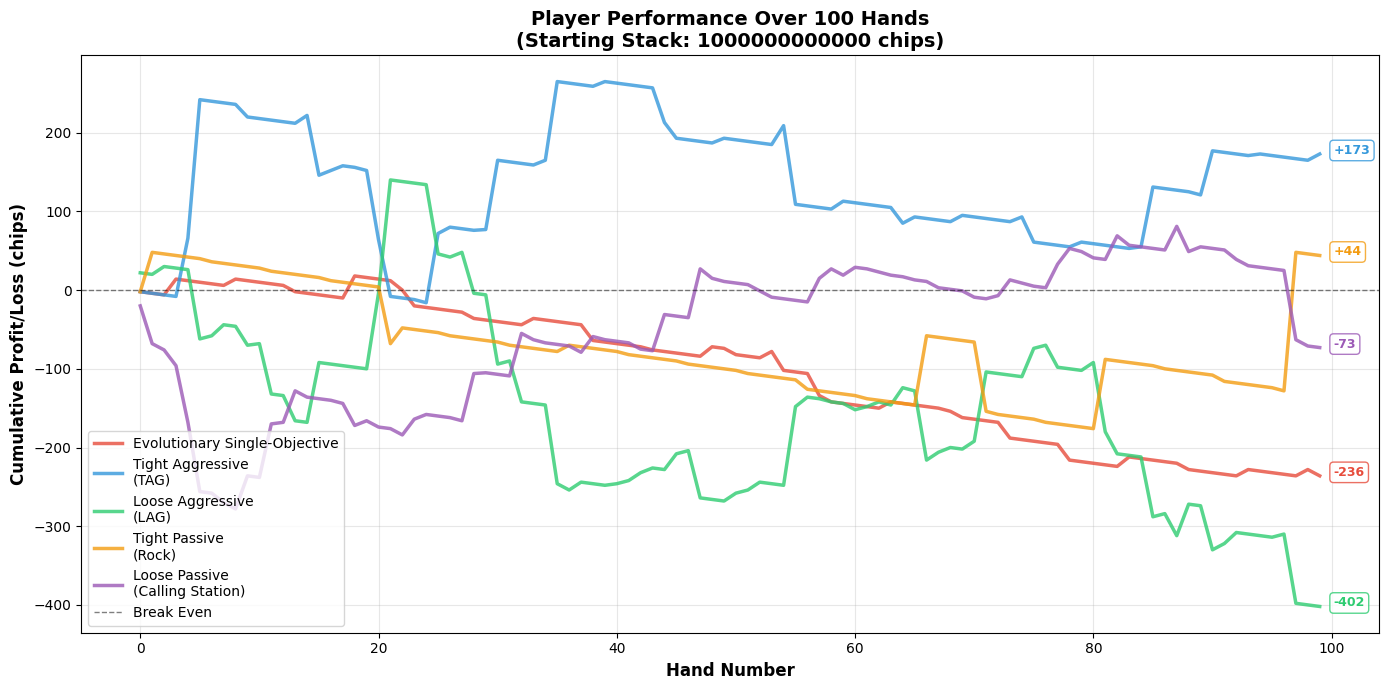


FINAL RESULTS SUMMARY
Starting stack: 1,000,000,000,000 chips

Evolutionary Single-Objective  | Final: 999,999,999,878 | P/L: -122 (-0.00%)
Tight Aggressive
(TAG)         | Final: 1,000,000,000,287 | P/L: +287 (+0.00%)
Loose Aggressive
(LAG)         | Final: 999,999,999,672 | P/L: -328 (-0.00%)
Tight Passive
(Rock)           | Final: 1,000,000,000,164 | P/L: +164 (+0.00%)
Loose Passive
(Calling Station) | Final: 999,999,999,999 | P/L: -1 (-0.00%)


In [26]:
plot_cumulative_rewards(rewards_over_time, player_names)

## Multi-Objective Evolutionary Agent

In the following section, I will create and train, via an evolutionary algorithm, a poker player with the multiple objectives of maximizing rewards (winnings) against each of the other four player types.

In [27]:
class AgentEvolutionaryMultiObjective(EvolutionaryPokerAgent):
    """
    A poker agent that uses a multi-objective evolutionary algorithm
    to learn each of its policy's parameters.
    """

    def __init__(self) -> None:
        super().__init__()

        self.N_FEATURES = 13  # Need to add on the 4 for the different styles present

    def encode_observation_vector(self, observation: ObservableState) -> np.ndarray:
        φ = super().encode_observation_vector(observation)

        players_present = np.array(
            [
                int(observation.tag_present),
                int(observation.lag_present),
                int(observation.tp_present),
                int(observation.lp_present),
            ]
        )

        return np.append(φ, players_present)

    def π(self, observation: ObservableState, θ: np.ndarray, **kwargs) -> ActionType:
        if θ is None:
            raise ValueError("θ must be provided for the evolutionary agent.")
        W, b = self.decode_theta(θ)
        φ = self.encode_observation_vector(observation)
        logits = W @ φ + b

        # Create a mask for available actions
        mask = np.array(
            [
                observation.can_fold,
                observation.can_check_or_call,
                observation.can_complete_bet_or_raise_to,
            ],
            dtype=bool,
        )

        action_probs = self.softmax(logits, mask=mask)
        action_index = np.random.choice(range(len(action_probs)), p=action_probs)
        action = ActionType(action_index)
        if (
            action == ActionType.FOLD
            and observation.can_check_or_call
            and observation.checking_or_calling_amount == 0
        ):
            action = (
                ActionType.CHECK_OR_CALL
            )  # avoid folding when we can check for free
        return action

## Configure Environments for Multi-Objective Evolutionary Agent

The following environments are configured for evaluating the multi-objective agent:

- Evolutionary agent vs. all four player types (general-purpose policy)
- Evolutionary agent vs. tight-aggressive player
- Evolutionary agent vs. loose-aggressive player
- Evolutionary agent vs. tight-passive player
- Evolutionary agent vs. loose-passive player

In [28]:
player_0_gp = PokerPlayer(
    poker_agent=AgentEvolutionaryMultiObjective(), player_index=0, stack=starting_stack
)
player_1_gp = PokerPlayer(
    poker_agent=AgentTightAggressive(), player_index=1, stack=starting_stack
)
player_2_gp = PokerPlayer(
    poker_agent=AgentLooseAggressive(), player_index=2, stack=starting_stack
)
player_3_gp = PokerPlayer(
    poker_agent=AgentTightPassive(), player_index=3, stack=starting_stack
)
player_4_gp = PokerPlayer(
    poker_agent=AgentLoosePassive(), player_index=4, stack=starting_stack
)

players_gp = [player_0_gp, player_1_gp, player_2_gp, player_3_gp, player_4_gp]
multi_objective_gp_env = FixedLimitTexasHoldemEnvironment(players=players_gp)

player_0_tag = PokerPlayer(
    poker_agent=AgentEvolutionaryMultiObjective(), player_index=0, stack=starting_stack
)
player_1_tag = PokerPlayer(
    poker_agent=AgentTightAggressive(), player_index=1, stack=starting_stack
)

players_tag = [player_0_tag, player_1_tag]
multi_objective_tag_env = FixedLimitTexasHoldemEnvironment(players=players_tag)

player_0_lag = PokerPlayer(
    poker_agent=AgentEvolutionaryMultiObjective(), player_index=0, stack=starting_stack
)
player_1_lag = PokerPlayer(
    poker_agent=AgentLooseAggressive(), player_index=1, stack=starting_stack
)

players_lag = [player_0_lag, player_1_lag]
multi_objective_lag_env = FixedLimitTexasHoldemEnvironment(players=players_lag)

player_0_tp = PokerPlayer(
    poker_agent=AgentEvolutionaryMultiObjective(), player_index=0, stack=starting_stack
)
player_1_tp = PokerPlayer(
    poker_agent=AgentTightPassive(), player_index=1, stack=starting_stack
)

players_tp = [player_0_tp, player_1_tp]
multi_objective_tp_env = FixedLimitTexasHoldemEnvironment(players=players_tp)

player_0_lp = PokerPlayer(
    poker_agent=AgentEvolutionaryMultiObjective(), player_index=0, stack=starting_stack
)
player_1_lp = PokerPlayer(
    poker_agent=AgentLoosePassive(), player_index=1, stack=starting_stack
)

players_lp = [player_0_lp, player_1_lp]
multi_objective_lp_env = FixedLimitTexasHoldemEnvironment(players=players_lp)

## Multi-Objective Fitness Function

The following fitness function will be used to evaluate our parameter vector (θ) by playing several hands of poker in each of the multi-objective environments and returning the average reward for each environment.

In [29]:
def fitness_multi_objective(
    θ: np.ndarray,
) -> tuple[float]:
    """
    ChatGPT 5.1 prompt - help me convert my fitness_single_objective fitness function
    into a multi-objective fitness function using the environments above.

    Plays multiple hands and returns average profit from each environment
    as fitness.
    Args:
        θ (np.ndarray): The parameter vector for the evolutionary agent.
    Returns:
        tuple[float]: The average profits from each environment as fitness.
    """
    num_hands = 100
    # A reward for each environment:
    # (gp, tag, lag, tp, lp)
    total_reward = np.zeros(5)

    envs_and_players = [
        (multi_objective_gp_env, players_gp),
        (multi_objective_tag_env, players_tag),
        (multi_objective_lag_env, players_lag),
        (multi_objective_tp_env, players_tp),
        (multi_objective_lp_env, players_lp),
    ]

    for _ in tqdm(range(num_hands), desc="Evaluating fitness..."):
        for i, (env, players) in enumerate(envs_and_players):
            rewards = play_one_hand_of_poker(
                env=env,
                players=players,
                actions_taken=[[] for _ in players],  # No need to track actions here
                θ=θ,
            )
            total_reward[i] = rewards[0]  # Reward for the evolutionary agent
    average_reward = tuple(total_reward / num_hands)
    return average_reward

## Configure Evolutionary Algorithm for Multi-Objective Learning

In [30]:
# maximize fitness using multiple objectives weighted equally
creator.create("FitnessMulti", base.Fitness, weights=(1.0, 1.0, 1.0, 1.0, 1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()

# register a tool to generate candidate solutions
toolbox.register("attr_float", random.gauss, 0.0, 1.0)

# Should be 13 * 3 + 3 = 42 for our chromosome size
chromosome_size = (
    player_0_gp.poker_agent.N_FEATURES * player_0_gp.poker_agent.N_ACTIONS
    + player_0_gp.poker_agent.N_ACTIONS
)
assert chromosome_size == 42, f"Expected chromosome size 42, got {chromosome_size}"

toolbox.register(
    "individual",
    tools.initRepeat,
    creator.Individual,
    toolbox.attr_float,
    n=chromosome_size,
)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# register our evaluation/fitness function
toolbox.register("evaluate", fitness_multi_objective)

# register our crossover/mating operator
toolbox.register("mate", tools.cxTwoPoint)

# define the mutation parameters and register the mutation operator
sigma = 0.1  # standard deviation for the Gaussian mutation
mutation_probability = 0.2  # probability of mutation

toolbox.register(
    "mutate",
    tools.mutGaussian,  # Gaussian mutation adds noise from the Gaussian/normal distribution
    mu=0.0,
    sigma=sigma,
    indpb=mutation_probability,
)

# NGSA-II selection algorithm recommended by ChatGPT 5.1 for multi-objective optimization
toolbox.register("select", tools.selNSGA2)

# use multiprocessing - doesn't work in notebooks
# pool = Pool()
# toolbox.register("map", pool.map)

In [31]:
LOAD_BEST_THETA_MULTI_OBJECTIVE = (
    True  # Set to False to rerun the evolution, True loads the best θ from a file.
)

if LOAD_BEST_THETA_MULTI_OBJECTIVE:
    best_theta_multi_objective_gp = np.load("best_theta_multi_objective_gp.npy")
    print(
        f"Loaded best_theta_multi_objective_gp with shape: {best_theta_multi_objective_gp.shape}"
    )
    best_theta_multi_objective_tag = np.load("best_theta_multi_objective_tag.npy")
    print(
        f"Loaded best_theta_multi_objective_tag with shape: {best_theta_multi_objective_tag.shape}"
    )
    best_theta_multi_objective_lag = np.load("best_theta_multi_objective_lag.npy")
    print(
        f"Loaded best_theta_multi_objective_lag with shape: {best_theta_multi_objective_lag.shape}"
    )
    best_theta_multi_objective_tp = np.load("best_theta_multi_objective_tp.npy")
    print(
        f"Loaded best_theta_multi_objective_tp with shape: {best_theta_multi_objective_tp.shape}"
    )
    best_theta_multi_objective_lp = np.load("best_theta_multi_objective_lp.npy")
    print(
        f"Loaded best_theta_multi_objective_lp with shape: {best_theta_multi_objective_lp.shape}"
    )
else:
    POPULATION_SIZE = 100
    NUM_GENERATIONS = 50
    CROSSOVER_PROBABILITY = 0.50
    MUTATION_PROBABILITY = 0.3

    # Initialize the population
    pop = toolbox.population(n=POPULATION_SIZE)

    # Configure statistics
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean, axis=0)
    stats.register("std", np.std, axis=0)
    stats.register("min", np.min, axis=0)
    stats.register("max", np.max, axis=0)

    # Configure the logbook
    logbook = tools.Logbook()
    logbook.header = ["gen", "nevals", "avg", "std", "min", "max"]

    # Chat GPT 5.1 helped with this part. I modified the code produced from
    # this prompt: Help me modify the single-objective evolutionary algorithm for
    # multi-objective to find the best thetas for each playing style.

    # Evaluate each individual in the initial population
    not_evaluated = [individual for individual in pop if not individual.fitness.valid]
    fitnesses = map(toolbox.evaluate, not_evaluated)
    for individual, fitness in zip(not_evaluated, fitnesses):
        individual.fitness.values = fitness

    pop = toolbox.select(pop, len(pop))  # select the initial generation population

    # Initial generation log
    record = stats.compile(pop)
    logbook.record(gen=0, nevals=len(not_evaluated), **record)
    print(logbook.stream)

    # Run the evolutionary algorithm
    for generation in range(NUM_GENERATIONS):
        offspring = tools.selTournamentDCD(pop, len(pop))
        offspring = [toolbox.clone(ind) for ind in offspring]

        # Crossover and mutation
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CROSSOVER_PROBABILITY:
                toolbox.mate(child1, child2)
            if random.random() < MUTATION_PROBABILITY:
                toolbox.mutate(child1)
                toolbox.mutate(child2)

            del child1.fitness.values, child2.fitness.values

        # Evaluate invalid individuals
        not_evaluated = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, not_evaluated)
        for ind, fit in zip(not_evaluated, fitnesses):
            ind.fitness.values = fit

        # Combine and select next generation
        pop = toolbox.select(pop + offspring, POPULATION_SIZE)

        # Log the generation stats
        record = stats.compile(pop)
        logbook.record(gen=generation + 1, nevals=len(not_evaluated), **record)
        print(logbook.stream)

    # Extract the pareto front
    pareto = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]

    best_theta_multi_objective_gp = max(pareto, key=lambda ind: ind.fitness.values[0])
    best_theta_multi_objective_tag = max(pareto, key=lambda ind: ind.fitness.values[1])
    best_theta_multi_objective_lag = max(pareto, key=lambda ind: ind.fitness.values[2])
    best_theta_multi_objective_tp = max(pareto, key=lambda ind: ind.fitness.values[3])
    best_theta_multi_objective_lp = max(pareto, key=lambda ind: ind.fitness.values[4])

Loaded best_theta_multi_objective_gp with shape: (42,)
Loaded best_theta_multi_objective_tag with shape: (42,)
Loaded best_theta_multi_objective_lag with shape: (42,)
Loaded best_theta_multi_objective_tp with shape: (42,)
Loaded best_theta_multi_objective_lp with shape: (42,)


In [32]:
# Delete the creator attributes so that the code can re-enter without warning
if "FitnessMulti" in dir(creator):
    del creator.FitnessMulti
if "Individual" in dir(creator):
    del creator.Individual

In [33]:
# Save the best thetas to skip re-training later
if not LOAD_BEST_THETA_MULTI_OBJECTIVE:
    np.save("best_theta_multi_objective_gp.npy", best_theta_multi_objective_gp)
    np.save("best_theta_multi_objective_tag.npy", best_theta_multi_objective_tag)
    np.save("best_theta_multi_objective_lag.npy", best_theta_multi_objective_lag)
    np.save("best_theta_multi_objective_tp.npy", best_theta_multi_objective_tp)
    np.save("best_theta_multi_objective_lp.npy", best_theta_multi_objective_lp)
print("Best theta - multi objective gp:", best_theta_multi_objective_gp)
print("Best theta - multi objective tag:", best_theta_multi_objective_tag)
print("Best theta - multi objective lag:", best_theta_multi_objective_lag)
print("Best theta - multi objective tp:", best_theta_multi_objective_tp)
print("Best theta - multi objective lp:", best_theta_multi_objective_lp)

Best theta - multi objective gp: [ 2.28776332 -0.08021455  0.23003281 -0.32985066 -0.37728178  0.62093794
 -0.85538706  0.44738063 -1.16792504 -1.43475829 -0.23018625  1.53260936
 -0.52222556 -0.10223927  1.09270598  1.0510561  -0.6253261  -1.20019782
  0.86985868  1.52757135 -0.4176907   2.27910696  0.21275609  0.12711567
  0.27245816 -1.74853932  0.7723117   0.8116424   1.06050583  0.20714966
 -0.36521389  0.73644556 -1.03745265  1.23384532  1.35537714  0.04903752
 -0.78497974 -1.02577602  1.11403632 -1.63887231  0.29997103  1.07199901]
Best theta - multi objective tag: [ 2.24594569 -0.12357358  0.13231081 -1.79646938 -1.54232112 -0.39976938
 -0.18023433  0.33176801 -0.70161858 -0.03983827 -0.53345303 -0.74221934
 -1.28573869 -1.08860787 -0.39279195  1.14005667  1.15214782 -1.13848465
  0.40055739  0.20682158  0.0737671   0.47684574 -0.45113001  0.31194047
 -0.06687634 -0.31227353 -0.73023667  1.21935193  1.40666722 -0.20806585
  1.1419028  -0.46647516 -0.13754814  0.02304008 -0.1059

## Multi-Objective (best θs) against the other agents.

In this section, I will let the multi-objective evolutionary agent compete against the other coded agents.

In [37]:
starting_stack = int(1e12)  # Start high to avoid going bankrupt
player_0 = PokerPlayer(
    poker_agent=AgentEvolutionaryMultiObjective(), player_index=0, stack=starting_stack
)
player_1 = PokerPlayer(
    poker_agent=AgentTightAggressive(), player_index=1, stack=starting_stack
)
player_2 = PokerPlayer(
    poker_agent=AgentLooseAggressive(), player_index=2, stack=starting_stack
)
player_3 = PokerPlayer(
    poker_agent=AgentTightPassive(), player_index=3, stack=starting_stack
)
player_4 = PokerPlayer(
    poker_agent=AgentLoosePassive(), player_index=4, stack=starting_stack
)
players = [player_0, player_1, player_2, player_3, player_4]
actions_taken = [[] for _ in players]
rewards_over_time = [[] for _ in players]

env = FixedLimitTexasHoldemEnvironment(players=players)
num_hands = 100

θs = [
    best_theta_multi_objective_gp,
    best_theta_multi_objective_tag,
    best_theta_multi_objective_lag,
    best_theta_multi_objective_tp,
    best_theta_multi_objective_lp,
]

for hand in tqdm(
    range(num_hands), desc="Playing hands with multi-objective agent vs. coded agents."
):
    rewards = play_one_hand_of_poker(
        env=env,
        players=players,
        actions_taken=actions_taken,
        # θs=θs,
        θ=best_theta_multi_objective_gp,
    )

    # Save the rewards for graphing later
    for i, reward in enumerate(rewards):
        rewards_over_time[i].append(reward)

    print(f"Completed hand {hand}.")
    print(f"Player stacks: {[player.stack for player in players]}")

Playing hands with multi-objective agent vs. coded agents.:   1%|          | 1/100 [00:01<02:20,  1.42s/it]

Completed hand 0.
Player stacks: [1000000000138, 999999999998, 999999999900, 1000000000000, 999999999964]


Playing hands with multi-objective agent vs. coded agents.:   2%|▏         | 2/100 [00:01<01:17,  1.27it/s]

Completed hand 1.
Player stacks: [1000000000138, 999999999998, 999999999904, 999999999996, 999999999964]


Playing hands with multi-objective agent vs. coded agents.:   3%|▎         | 3/100 [00:02<00:55,  1.76it/s]

Completed hand 2.
Player stacks: [1000000000148, 999999999998, 999999999904, 999999999994, 999999999956]


Playing hands with multi-objective agent vs. coded agents.:   4%|▍         | 4/100 [00:02<00:46,  2.08it/s]

Completed hand 3.
Player stacks: [1000000000156, 999999999998, 999999999904, 999999999994, 999999999948]


Playing hands with multi-objective agent vs. coded agents.:   5%|▌         | 5/100 [00:02<00:48,  1.97it/s]

Completed hand 4.
Player stacks: [1000000000076, 1000000000086, 999999999904, 999999999994, 999999999940]


Playing hands with multi-objective agent vs. coded agents.:   6%|▌         | 6/100 [00:03<00:39,  2.36it/s]

Completed hand 5.
Player stacks: [1000000000068, 1000000000084, 999999999914, 999999999994, 999999999940]


Playing hands with multi-objective agent vs. coded agents.:   7%|▋         | 7/100 [00:03<00:42,  2.16it/s]

Completed hand 6.
Player stacks: [1000000000032, 1000000000084, 999999999912, 999999999990, 999999999982]


Playing hands with multi-objective agent vs. coded agents.:   8%|▊         | 8/100 [00:04<00:46,  1.98it/s]

Completed hand 7.
Player stacks: [999999999952, 1000000000084, 1000000000002, 999999999988, 999999999974]


Playing hands with multi-objective agent vs. coded agents.:   9%|▉         | 9/100 [00:05<00:50,  1.80it/s]

Completed hand 8.
Player stacks: [999999999884, 1000000000084, 1000000000090, 999999999988, 999999999954]


Playing hands with multi-objective agent vs. coded agents.:  10%|█         | 10/100 [00:05<00:50,  1.78it/s]

Completed hand 9.
Player stacks: [999999999976, 999999999992, 1000000000090, 999999999988, 999999999954]


Playing hands with multi-objective agent vs. coded agents.:  11%|█         | 11/100 [00:06<00:53,  1.65it/s]

Completed hand 10.
Player stacks: [1000000000090, 999999999990, 999999999998, 999999999988, 999999999934]


Playing hands with multi-objective agent vs. coded agents.:  12%|█▏        | 12/100 [00:06<00:53,  1.64it/s]

Completed hand 11.
Player stacks: [999999999990, 999999999990, 999999999996, 999999999984, 1000000000040]


Playing hands with multi-objective agent vs. coded agents.:  13%|█▎        | 13/100 [00:07<00:49,  1.76it/s]

Completed hand 12.
Player stacks: [1000000000000, 999999999990, 999999999996, 999999999982, 1000000000032]


Playing hands with multi-objective agent vs. coded agents.:  14%|█▍        | 14/100 [00:08<00:57,  1.48it/s]

Completed hand 13.
Player stacks: [999999999940, 999999999990, 999999999896, 999999999982, 1000000000192]


Playing hands with multi-objective agent vs. coded agents.:  15%|█▌        | 15/100 [00:08<00:54,  1.55it/s]

Completed hand 14.
Player stacks: [999999999864, 999999999986, 999999999896, 999999999982, 1000000000272]


Playing hands with multi-objective agent vs. coded agents.:  16%|█▌        | 16/100 [00:09<00:48,  1.72it/s]

Completed hand 15.
Player stacks: [999999999824, 999999999984, 999999999938, 999999999982, 1000000000272]


Playing hands with multi-objective agent vs. coded agents.:  17%|█▋        | 17/100 [00:09<00:49,  1.69it/s]

Completed hand 16.
Player stacks: [999999999760, 999999999984, 1000000000006, 999999999978, 1000000000272]


Playing hands with multi-objective agent vs. coded agents.:  18%|█▊        | 18/100 [00:10<00:44,  1.84it/s]

Completed hand 17.
Player stacks: [999999999770, 999999999984, 1000000000006, 999999999976, 1000000000264]


Playing hands with multi-objective agent vs. coded agents.:  19%|█▉        | 19/100 [00:10<00:41,  1.94it/s]

Completed hand 18.
Player stacks: [999999999682, 999999999984, 1000000000006, 999999999976, 1000000000352]


Playing hands with multi-objective agent vs. coded agents.:  20%|██        | 20/100 [00:11<00:37,  2.15it/s]

Completed hand 19.
Player stacks: [999999999694, 999999999980, 1000000000006, 999999999976, 1000000000344]


Playing hands with multi-objective agent vs. coded agents.:  21%|██        | 21/100 [00:11<00:37,  2.10it/s]

Completed hand 20.
Player stacks: [999999999728, 999999999978, 1000000000002, 999999999976, 1000000000316]


Playing hands with multi-objective agent vs. coded agents.:  22%|██▏       | 22/100 [00:12<00:42,  1.83it/s]

Completed hand 21.
Player stacks: [999999999708, 999999999978, 999999999918, 1000000000080, 1000000000316]


Playing hands with multi-objective agent vs. coded agents.:  23%|██▎       | 23/100 [00:13<00:45,  1.69it/s]

Completed hand 22.
Player stacks: [999999999620, 999999999978, 1000000000096, 1000000000078, 1000000000228]


Playing hands with multi-objective agent vs. coded agents.:  24%|██▍       | 24/100 [00:13<00:41,  1.84it/s]

Completed hand 23.
Player stacks: [999999999600, 999999999978, 1000000000096, 1000000000078, 1000000000248]


Playing hands with multi-objective agent vs. coded agents.:  25%|██▌       | 25/100 [00:14<00:42,  1.78it/s]

Completed hand 24.
Player stacks: [999999999556, 999999999974, 1000000000096, 1000000000078, 1000000000296]


Playing hands with multi-objective agent vs. coded agents.:  26%|██▌       | 26/100 [00:14<00:42,  1.72it/s]

Completed hand 25.
Player stacks: [999999999620, 999999999914, 1000000000092, 1000000000078, 1000000000296]


Playing hands with multi-objective agent vs. coded agents.:  27%|██▋       | 27/100 [00:15<00:44,  1.63it/s]

Completed hand 26.
Player stacks: [999999999532, 999999999914, 1000000000184, 1000000000074, 1000000000296]


Playing hands with multi-objective agent vs. coded agents.:  28%|██▊       | 28/100 [00:15<00:38,  1.85it/s]

Completed hand 27.
Player stacks: [999999999542, 999999999914, 1000000000184, 1000000000072, 1000000000288]


Playing hands with multi-objective agent vs. coded agents.:  29%|██▉       | 29/100 [00:16<00:38,  1.83it/s]

Completed hand 28.
Player stacks: [999999999620, 999999999914, 1000000000108, 1000000000072, 1000000000286]


Playing hands with multi-objective agent vs. coded agents.:  30%|███       | 30/100 [00:16<00:38,  1.82it/s]

Completed hand 29.
Player stacks: [999999999700, 999999999834, 1000000000108, 1000000000072, 1000000000286]


Playing hands with multi-objective agent vs. coded agents.:  31%|███       | 31/100 [00:17<00:34,  1.99it/s]

Completed hand 30.
Player stacks: [999999999672, 999999999832, 1000000000138, 1000000000072, 1000000000286]


Playing hands with multi-objective agent vs. coded agents.:  32%|███▏      | 32/100 [00:17<00:37,  1.81it/s]

Completed hand 31.
Player stacks: [999999999756, 999999999832, 1000000000066, 1000000000068, 1000000000278]


Playing hands with multi-objective agent vs. coded agents.:  33%|███▎      | 33/100 [00:18<00:33,  2.00it/s]

Completed hand 32.
Player stacks: [999999999770, 999999999832, 1000000000066, 1000000000066, 1000000000266]


Playing hands with multi-objective agent vs. coded agents.:  34%|███▍      | 34/100 [00:18<00:28,  2.30it/s]

Completed hand 33.
Player stacks: [999999999778, 999999999832, 1000000000066, 1000000000066, 1000000000258]


Playing hands with multi-objective agent vs. coded agents.:  35%|███▌      | 35/100 [00:19<00:28,  2.26it/s]

Completed hand 34.
Player stacks: [999999999802, 999999999828, 1000000000066, 1000000000066, 1000000000238]


Playing hands with multi-objective agent vs. coded agents.:  36%|███▌      | 36/100 [00:19<00:26,  2.41it/s]

Completed hand 35.
Player stacks: [999999999812, 999999999826, 1000000000058, 1000000000066, 1000000000238]


Playing hands with multi-objective agent vs. coded agents.:  37%|███▋      | 37/100 [00:19<00:26,  2.37it/s]

Completed hand 36.
Player stacks: [999999999826, 999999999826, 1000000000056, 1000000000054, 1000000000238]


Playing hands with multi-objective agent vs. coded agents.:  38%|███▊      | 38/100 [00:20<00:26,  2.36it/s]

Completed hand 37.
Player stacks: [999999999826, 999999999826, 1000000000052, 1000000000052, 1000000000244]


Playing hands with multi-objective agent vs. coded agents.:  39%|███▉      | 39/100 [00:20<00:25,  2.35it/s]

Completed hand 38.
Player stacks: [999999999846, 999999999826, 1000000000052, 1000000000052, 1000000000224]


Playing hands with multi-objective agent vs. coded agents.:  40%|████      | 40/100 [00:21<00:24,  2.47it/s]

Completed hand 39.
Player stacks: [999999999830, 999999999822, 1000000000072, 1000000000052, 1000000000224]


Playing hands with multi-objective agent vs. coded agents.:  41%|████      | 41/100 [00:21<00:27,  2.18it/s]

Completed hand 40.
Player stacks: [999999999826, 999999999926, 999999999972, 1000000000052, 1000000000224]


Playing hands with multi-objective agent vs. coded agents.:  42%|████▏     | 42/100 [00:22<00:26,  2.19it/s]

Completed hand 41.
Player stacks: [999999999840, 999999999926, 999999999970, 1000000000048, 1000000000216]


Playing hands with multi-objective agent vs. coded agents.:  43%|████▎     | 43/100 [00:22<00:31,  1.80it/s]

Completed hand 42.
Player stacks: [999999999776, 999999999926, 1000000000040, 1000000000046, 1000000000212]


Playing hands with multi-objective agent vs. coded agents.:  44%|████▍     | 44/100 [00:23<00:30,  1.84it/s]

Completed hand 43.
Player stacks: [999999999792, 999999999926, 1000000000040, 1000000000046, 1000000000196]


Playing hands with multi-objective agent vs. coded agents.:  45%|████▌     | 45/100 [00:23<00:28,  1.90it/s]

Completed hand 44.
Player stacks: [999999999816, 999999999922, 1000000000040, 1000000000046, 1000000000176]


Playing hands with multi-objective agent vs. coded agents.:  46%|████▌     | 46/100 [00:24<00:32,  1.67it/s]

Completed hand 45.
Player stacks: [999999999898, 999999999920, 999999999968, 1000000000046, 1000000000168]


Playing hands with multi-objective agent vs. coded agents.:  47%|████▋     | 47/100 [00:24<00:25,  2.07it/s]

Completed hand 46.
Player stacks: [999999999904, 999999999920, 999999999966, 1000000000042, 1000000000168]


Playing hands with multi-objective agent vs. coded agents.:  48%|████▊     | 48/100 [00:25<00:28,  1.82it/s]

Completed hand 47.
Player stacks: [1000000000018, 999999999920, 999999999874, 1000000000040, 1000000000148]


Playing hands with multi-objective agent vs. coded agents.:  49%|████▉     | 49/100 [00:26<00:28,  1.81it/s]

Completed hand 48.
Player stacks: [1000000000002, 999999999920, 999999999774, 1000000000040, 1000000000264]


Playing hands with multi-objective agent vs. coded agents.:  50%|█████     | 50/100 [00:26<00:26,  1.86it/s]

Completed hand 49.
Player stacks: [1000000000034, 999999999916, 999999999774, 1000000000040, 1000000000236]


Playing hands with multi-objective agent vs. coded agents.:  51%|█████     | 51/100 [00:27<00:28,  1.75it/s]

Completed hand 50.
Player stacks: [999999999958, 999999999914, 999999999860, 1000000000040, 1000000000228]


Playing hands with multi-objective agent vs. coded agents.:  52%|█████▏    | 52/100 [00:27<00:26,  1.80it/s]

Completed hand 51.
Player stacks: [999999999894, 999999999914, 999999999928, 1000000000036, 1000000000228]


Playing hands with multi-objective agent vs. coded agents.:  53%|█████▎    | 53/100 [00:28<00:21,  2.15it/s]

Completed hand 52.
Player stacks: [999999999904, 999999999914, 999999999928, 1000000000034, 1000000000220]


Playing hands with multi-objective agent vs. coded agents.:  54%|█████▍    | 54/100 [00:28<00:20,  2.20it/s]

Completed hand 53.
Player stacks: [999999999988, 999999999914, 999999999928, 1000000000034, 1000000000136]


Playing hands with multi-objective agent vs. coded agents.:  55%|█████▌    | 55/100 [00:28<00:20,  2.20it/s]

Completed hand 54.
Player stacks: [999999999968, 999999999910, 999999999928, 1000000000034, 1000000000160]


Playing hands with multi-objective agent vs. coded agents.:  56%|█████▌    | 56/100 [00:29<00:21,  2.00it/s]

Completed hand 55.
Player stacks: [999999999888, 999999999906, 1000000000012, 1000000000034, 1000000000160]


Playing hands with multi-objective agent vs. coded agents.:  57%|█████▋    | 57/100 [00:30<00:21,  2.01it/s]

Completed hand 56.
Player stacks: [999999999896, 999999999906, 1000000000008, 1000000000030, 1000000000160]


Playing hands with multi-objective agent vs. coded agents.:  58%|█████▊    | 58/100 [00:30<00:23,  1.80it/s]

Completed hand 57.
Player stacks: [999999999808, 999999999906, 1000000000186, 1000000000028, 1000000000072]


Playing hands with multi-objective agent vs. coded agents.:  59%|█████▉    | 59/100 [00:31<00:22,  1.82it/s]

Completed hand 58.
Player stacks: [999999999732, 999999999906, 1000000000186, 1000000000028, 1000000000148]


Playing hands with multi-objective agent vs. coded agents.:  60%|██████    | 60/100 [00:31<00:21,  1.89it/s]

Completed hand 59.
Player stacks: [999999999756, 999999999902, 1000000000186, 1000000000028, 1000000000128]


Playing hands with multi-objective agent vs. coded agents.:  61%|██████    | 61/100 [00:32<00:19,  2.03it/s]

Completed hand 60.
Player stacks: [999999999668, 999999999900, 1000000000276, 1000000000028, 1000000000128]


Playing hands with multi-objective agent vs. coded agents.:  62%|██████▏   | 62/100 [00:32<00:16,  2.33it/s]

Completed hand 61.
Player stacks: [999999999656, 999999999900, 1000000000292, 1000000000024, 1000000000128]


Playing hands with multi-objective agent vs. coded agents.:  63%|██████▎   | 63/100 [00:32<00:16,  2.25it/s]

Completed hand 62.
Player stacks: [999999999670, 999999999900, 1000000000292, 1000000000022, 1000000000116]


Playing hands with multi-objective agent vs. coded agents.:  64%|██████▍   | 64/100 [00:33<00:18,  1.94it/s]

Completed hand 63.
Player stacks: [999999999618, 999999999900, 1000000000192, 1000000000022, 1000000000268]


Playing hands with multi-objective agent vs. coded agents.:  65%|██████▌   | 65/100 [00:34<00:18,  1.86it/s]

Completed hand 64.
Player stacks: [999999999706, 999999999820, 1000000000192, 1000000000022, 1000000000260]


Playing hands with multi-objective agent vs. coded agents.:  66%|██████▌   | 66/100 [00:34<00:19,  1.78it/s]

Completed hand 65.
Player stacks: [999999999610, 999999999818, 1000000000290, 1000000000022, 1000000000260]


Playing hands with multi-objective agent vs. coded agents.:  67%|██████▋   | 67/100 [00:35<00:18,  1.80it/s]

Completed hand 66.
Player stacks: [999999999682, 999999999818, 1000000000222, 1000000000018, 1000000000260]


Playing hands with multi-objective agent vs. coded agents.:  68%|██████▊   | 68/100 [00:35<00:17,  1.86it/s]

Completed hand 67.
Player stacks: [999999999606, 999999999818, 1000000000304, 1000000000016, 1000000000256]


Playing hands with multi-objective agent vs. coded agents.:  69%|██████▉   | 69/100 [00:36<00:16,  1.91it/s]

Completed hand 68.
Player stacks: [999999999614, 999999999818, 1000000000304, 1000000000016, 1000000000248]


Playing hands with multi-objective agent vs. coded agents.:  70%|███████   | 70/100 [00:36<00:15,  1.90it/s]

Completed hand 69.
Player stacks: [999999999514, 999999999814, 1000000000304, 1000000000016, 1000000000352]


Playing hands with multi-objective agent vs. coded agents.:  71%|███████   | 71/100 [00:37<00:15,  1.82it/s]

Completed hand 70.
Player stacks: [999999999544, 999999999812, 1000000000296, 1000000000016, 1000000000332]


Playing hands with multi-objective agent vs. coded agents.:  72%|███████▏  | 72/100 [00:38<00:18,  1.51it/s]

Completed hand 71.
Player stacks: [999999999660, 999999999812, 1000000000204, 1000000000012, 1000000000312]


Playing hands with multi-objective agent vs. coded agents.:  73%|███████▎  | 73/100 [00:38<00:15,  1.79it/s]

Completed hand 72.
Player stacks: [999999999670, 999999999812, 1000000000204, 1000000000010, 1000000000304]


Playing hands with multi-objective agent vs. coded agents.:  74%|███████▍  | 74/100 [00:39<00:13,  1.91it/s]

Completed hand 73.
Player stacks: [999999999646, 999999999812, 1000000000204, 1000000000010, 1000000000328]


Playing hands with multi-objective agent vs. coded agents.:  75%|███████▌  | 75/100 [00:39<00:14,  1.78it/s]

Completed hand 74.
Player stacks: [999999999602, 999999999808, 1000000000204, 1000000000010, 1000000000376]


Playing hands with multi-objective agent vs. coded agents.:  76%|███████▌  | 76/100 [00:40<00:13,  1.81it/s]

Completed hand 75.
Player stacks: [999999999664, 999999999806, 1000000000152, 1000000000010, 1000000000368]


Playing hands with multi-objective agent vs. coded agents.:  77%|███████▋  | 77/100 [00:40<00:12,  1.80it/s]

Completed hand 76.
Player stacks: [999999999738, 999999999806, 1000000000150, 999999999938, 1000000000368]


Playing hands with multi-objective agent vs. coded agents.:  78%|███████▊  | 78/100 [00:41<00:11,  1.95it/s]

Completed hand 77.
Player stacks: [999999999752, 999999999806, 1000000000150, 999999999936, 1000000000356]


Playing hands with multi-objective agent vs. coded agents.:  79%|███████▉  | 79/100 [00:41<00:09,  2.23it/s]

Completed hand 78.
Player stacks: [999999999760, 999999999806, 1000000000150, 999999999936, 1000000000348]


Playing hands with multi-objective agent vs. coded agents.:  80%|████████  | 80/100 [00:42<00:09,  2.09it/s]

Completed hand 79.
Player stacks: [999999999672, 999999999894, 1000000000150, 999999999936, 1000000000348]


Playing hands with multi-objective agent vs. coded agents.:  81%|████████  | 81/100 [00:42<00:08,  2.36it/s]

Completed hand 80.
Player stacks: [999999999664, 999999999892, 1000000000160, 999999999936, 1000000000348]


Playing hands with multi-objective agent vs. coded agents.:  82%|████████▏ | 82/100 [00:43<00:08,  2.20it/s]

Completed hand 81.
Player stacks: [999999999576, 999999999892, 1000000000252, 999999999932, 1000000000348]


Playing hands with multi-objective agent vs. coded agents.:  83%|████████▎ | 83/100 [00:43<00:07,  2.15it/s]

Completed hand 82.
Player stacks: [999999999528, 999999999892, 1000000000252, 999999999930, 1000000000398]


Playing hands with multi-objective agent vs. coded agents.:  84%|████████▍ | 84/100 [00:44<00:07,  2.05it/s]

Completed hand 83.
Player stacks: [999999999468, 999999999892, 1000000000252, 999999999930, 1000000000458]


Playing hands with multi-objective agent vs. coded agents.:  85%|████████▌ | 85/100 [00:44<00:06,  2.17it/s]

Completed hand 84.
Player stacks: [999999999484, 999999999888, 1000000000252, 999999999930, 1000000000446]


Playing hands with multi-objective agent vs. coded agents.:  86%|████████▌ | 86/100 [00:44<00:06,  2.13it/s]

Completed hand 85.
Player stacks: [999999999546, 999999999886, 1000000000192, 999999999930, 1000000000446]


Playing hands with multi-objective agent vs. coded agents.:  87%|████████▋ | 87/100 [00:45<00:06,  1.95it/s]

Completed hand 86.
Player stacks: [999999999446, 999999999886, 1000000000190, 999999999926, 1000000000552]


Playing hands with multi-objective agent vs. coded agents.:  88%|████████▊ | 88/100 [00:46<00:05,  2.02it/s]

Completed hand 87.
Player stacks: [999999999464, 999999999886, 1000000000190, 999999999924, 1000000000536]


Playing hands with multi-objective agent vs. coded agents.:  89%|████████▉ | 89/100 [00:46<00:05,  2.13it/s]

Completed hand 88.
Player stacks: [999999999492, 999999999886, 1000000000190, 999999999924, 1000000000508]


Playing hands with multi-objective agent vs. coded agents.:  90%|█████████ | 90/100 [00:46<00:04,  2.19it/s]

Completed hand 89.
Player stacks: [999999999508, 999999999882, 1000000000190, 999999999924, 1000000000496]


Playing hands with multi-objective agent vs. coded agents.:  91%|█████████ | 91/100 [00:47<00:03,  2.41it/s]

Completed hand 90.
Player stacks: [999999999500, 999999999880, 1000000000200, 999999999924, 1000000000496]


Playing hands with multi-objective agent vs. coded agents.:  92%|█████████▏| 92/100 [00:47<00:03,  2.06it/s]

Completed hand 91.
Player stacks: [999999999592, 999999999880, 1000000000112, 999999999920, 1000000000496]


Playing hands with multi-objective agent vs. coded agents.:  93%|█████████▎| 93/100 [00:48<00:03,  1.86it/s]

Completed hand 92.
Player stacks: [999999999504, 999999999880, 1000000000206, 999999999918, 1000000000492]


Playing hands with multi-objective agent vs. coded agents.:  94%|█████████▍| 94/100 [00:49<00:03,  1.85it/s]

Completed hand 93.
Player stacks: [999999999412, 999999999880, 1000000000318, 999999999918, 1000000000472]


Playing hands with multi-objective agent vs. coded agents.:  95%|█████████▌| 95/100 [00:49<00:02,  1.95it/s]

Completed hand 94.
Player stacks: [999999999444, 999999999876, 1000000000318, 999999999918, 1000000000444]


Playing hands with multi-objective agent vs. coded agents.:  96%|█████████▌| 96/100 [00:50<00:02,  1.79it/s]

Completed hand 95.
Player stacks: [999999999372, 999999999952, 1000000000314, 999999999918, 1000000000444]


Playing hands with multi-objective agent vs. coded agents.:  97%|█████████▋| 97/100 [00:50<00:01,  1.71it/s]

Completed hand 96.
Player stacks: [999999999324, 999999999952, 1000000000340, 999999999914, 1000000000470]


Playing hands with multi-objective agent vs. coded agents.:  98%|█████████▊| 98/100 [00:51<00:01,  1.57it/s]

Completed hand 97.
Player stacks: [999999999236, 999999999952, 1000000000332, 999999999912, 1000000000568]


Playing hands with multi-objective agent vs. coded agents.:  99%|█████████▉| 99/100 [00:52<00:00,  1.61it/s]

Completed hand 98.
Player stacks: [999999999160, 999999999952, 1000000000332, 999999999912, 1000000000644]


Playing hands with multi-objective agent vs. coded agents.: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]

Completed hand 99.
Player stacks: [999999999184, 999999999948, 1000000000332, 999999999912, 1000000000624]


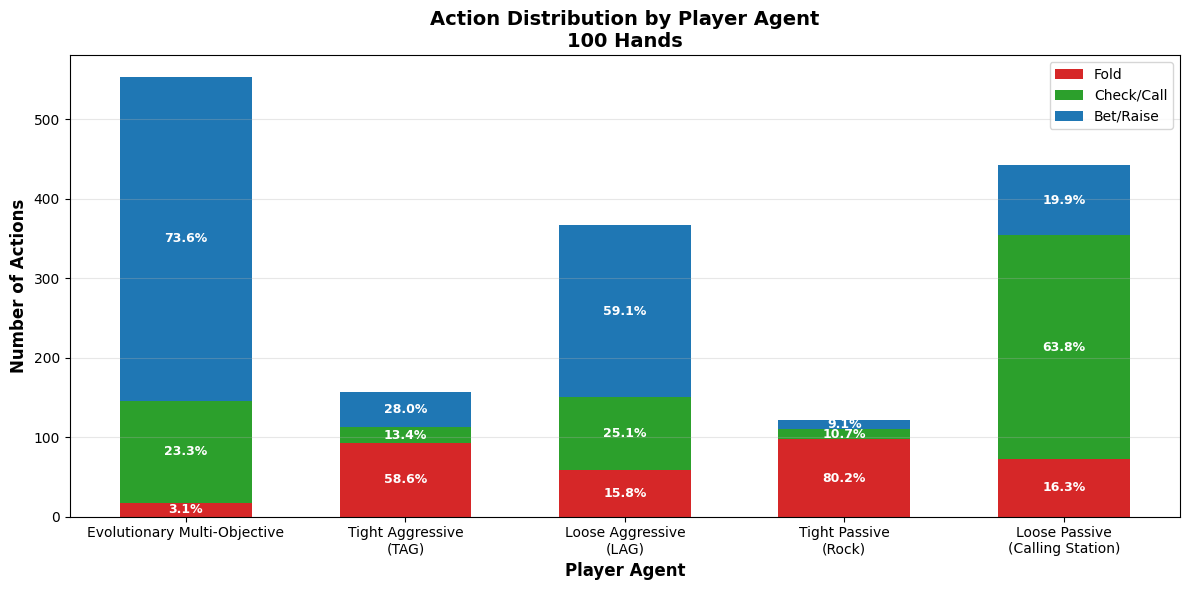

In [38]:
player_names = [
        "Evolutionary Multi-Objective",
        "Tight Aggressive\n(TAG)",
        "Loose Aggressive\n(LAG)",
        "Tight Passive\n(Rock)",
        "Loose Passive\n(Calling Station)",
    ]
plot_actions_taken(actions_taken, player_names)

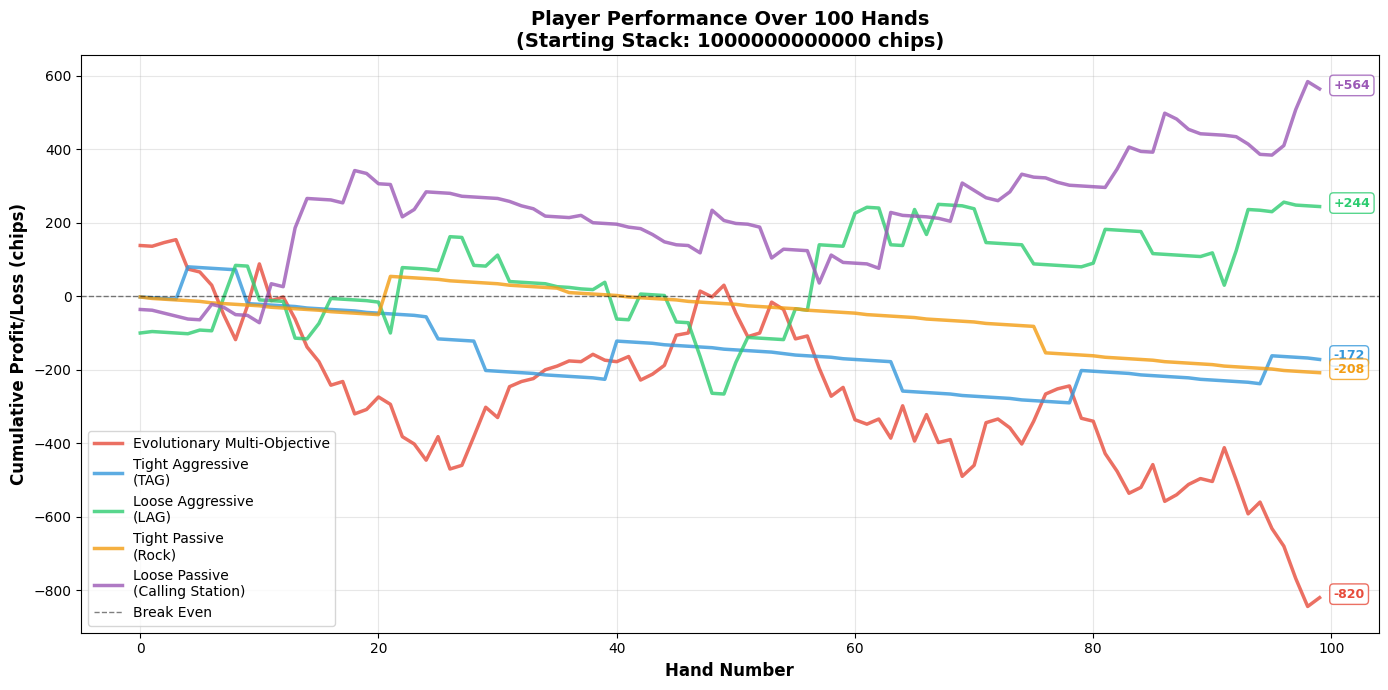


FINAL RESULTS SUMMARY
Starting stack: 1,000,000,000,000 chips

Evolutionary Multi-Objective   | Final: 999,999,999,184 | P/L: -816 (-0.00%)
Tight Aggressive
(TAG)         | Final: 999,999,999,948 | P/L: -52 (-0.00%)
Loose Aggressive
(LAG)         | Final: 1,000,000,000,332 | P/L: +332 (+0.00%)
Tight Passive
(Rock)           | Final: 999,999,999,912 | P/L: -88 (-0.00%)
Loose Passive
(Calling Station) | Final: 1,000,000,000,624 | P/L: +624 (+0.00%)


In [39]:
plot_cumulative_rewards(rewards_over_time, player_names)